# Problem 2: Getting familiar with TensorFlow

*TensorFlow* is one of the most popular deep learning framework developed by Google. If you are new to TensorFlow, please read and play with the sample in [Getting started with TensorFlow](https://www.tensorflow.org/get_started/get_started) to get started.

* <b>Learning Objective:</b> In Problem 1, you implemented a fully connected network from scratch on your own. Very tedious to do it all by yourself, right? Well, we actually feel the same thing, that's why we are using tools instead of doing everything from scratch, lonely and depressed. For this part of the assignment, we will familiarize you with a widely-used deep learning framework developed by Google, TensorFlow and walk you through convolutional neural networks and show how to train them.
* <b>Provided Codes:</b> We provide the Template class for a simple CNN model as BaseModel, predefined skeletons for conv2d() and max_pool(), as well as the dataset preprocessing parts.
* <b>TODOs:</b> You are asked to implement the BaseModel following the detailed instrunctions and design your own model in YourModel to achieve a reasonably good performance for classification task on CIFAR-10 dataset.

## Install and import libraries
Install tensorflow and matplotlib.

```
pip install -U tensorflow matplotlib
```

In [1]:
# Import required libraries
# Add whatever you want
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

print "TensorFlow Version {}".format(tf.__version__)

TensorFlow Version 1.3.0


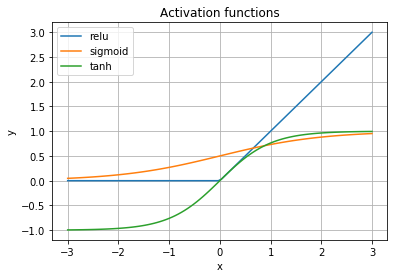

In [2]:
# Test matplotlib
x = np.linspace(-3, 3, 100)

plt.plot(x, np.maximum(0, x), label='relu')
plt.plot(x, 1/(1 + np.exp(-x)), label='sigmoid')
plt.plot(x, (1 - np.exp(-2 * x))/(1 + np.exp(-2 * x)), label='tanh')

plt.xlabel('x')
plt.ylabel('y')

plt.title("Activation functions")
plt.legend()
plt.grid(True)

plt.show()

In [2]:
# Test tensorflow
print('TensorFlow version: ' + tf.__version__)
a = tf.constant(2.0)
b = tf.constant(3.0)
c = a * b

sess = tf.Session()
result = sess.run([a, b, c])
print('%f * %f = %f' % (result[0], result[1], result[2]))
sess.close()

TensorFlow version: 1.3.0
2.000000 * 3.000000 = 6.000000


## Load datasets
Download [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz) and load the dataset. In this assignment, we will use all 50,000 images for training and 10,000 images for test.

In [5]:
# Configuration
num_training = 49000
num_validation = 50000 - num_training
num_test = 10000

def unpickle(file):
    import sys
    if sys.version_info.major == 2:
        import cPickle
        with open(file, 'rb') as fo:
            dict = cPickle.load(fo)
        return dict['data'], dict['labels']
    else:
        import pickle
        with open(file, 'rb') as fo:
            dict = pickle.load(fo, encoding='bytes')
        return dict[b'data'], dict[b'labels']

data_path = "data/cifar-10-batches-py/"    
def load_train_data():
    #############################################################################
    # TODO: Load training data from cifar-10 dataset                            #
    # Load five files from 'data_batch_1' to 'data_batch_5'                     #
    # Reshape images and labels to the shape of [50000, 32, 32, 3]              # 
    # and [50000], respectively                                                 #
    #############################################################################
    all_batches = []
    all_labels = []
    
    for b in range(1, 6):
        filepath = data_path + 'data_batch_%d' % (b, )
        batch, labels = unpickle(filepath)
        batch = batch.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("float")
        labels = np.array(labels)
        all_batches.append(batch)
        all_labels.append(labels)
    data_train = np.concatenate(all_batches)
    labels_train = np.concatenate(all_labels)
    return data_train[:num_training], labels_train[:num_training], data_train[num_training:], labels_train[num_training:]

    #############################################################################
    #                             END OF YOUR CODE                              #
    #############################################################################

def load_test_data():
    #############################################################################
    # TODO: Load testing data from cifar-10 dataset                             #
    # Load 'test_batch' file                                                    #
    # Reshape images and labels to the shape of [10000, 32, 32, 3]              #
    # and [10000], respectively                                                 #
    #############################################################################
    filepath = data_path + "test_batch"
    batch, labels = unpickle(filepath)
    batch = batch.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("float")
    labels = np.array(labels)
    return batch, labels

    #############################################################################
    #                             END OF YOUR CODE                              #
    #############################################################################

# Load cifar-10 data
X_train, Y_train, X_val, Y_val = load_train_data()
X_test, Y_test = load_test_data()

# Check the shape of the dataset
assert X_train.shape == (num_training, 32, 32, 3)
assert Y_train.shape == (num_training, )
assert X_val.shape == (num_validation, 32, 32, 3)
assert Y_val.shape == (num_validation, )
assert X_test.shape == (num_test, 32, 32, 3)
assert Y_test.shape == (10000, )

## Question 2-1

Using the code provided, implement a neural network architecture with an optimization routine according to the specification provided below.

**Model:**
- Input image with the size 32x32x3
- 7x7 convolutional layer with 32 filters, stride of 1, and padding 'SAME'
- ReLU activation layer
- 3x3 max pooling layer with a stride of 2
- 5x5 convolutional layer with 64 filters, stride of 1, and padding 'SAME'
- ReLU activation layer
- 3x3 max pooling layer with a stride of 2
- Flatten layer (8x8x64 -> 4096)
- Fully-connected layer with 384 output units (4096 -> 384)
- ReLU activation layer
- Fully-connected layer with 10 output units (384 -> 10)
- Output logits (10)

**Optimizer:**
- Adam optimizer

**Learning rate:**
- Set start learning rate as 5e-4 and apply exponential decay every 500 steps with a base of 0.96
- Use 'tf.train.exponential_decay' and 'tf.train.AdamOptimizer'

**Loss:**
- Softmax cross entropy loss
- Use 'tf.nn.softmax_cross_entropy_with_logits'


Your model **should** achieve about 60% accuracy on validation set in 5 epochs using provided evaluation code.

You can modify the template code as you want.

## Define your layers

In [6]:
# Define max pooling and conv layers
def conv2d(input, kernel_size, stride, num_filter):
    stride_shape = [1, stride, stride, 1]
    filter_shape = [kernel_size, kernel_size, input.get_shape()[3], num_filter]

    W = tf.get_variable('w', filter_shape, tf.float32, tf.random_normal_initializer(0.0, 0.02))
    b = tf.get_variable('b', [1, 1, 1, num_filter], initializer=tf.constant_initializer(0.0))
    return tf.nn.conv2d(input, W, stride_shape, padding='SAME') + b

def max_pool(input, kernel_size, stride):
    ksize = [1, kernel_size, kernel_size, 1]
    strides = [1, stride, stride, 1]
    return tf.nn.max_pool(input, ksize=ksize, strides=strides, padding='SAME')

#############################################################################
# TODO: You can add any layers (fully-connected, normalization)             #
#############################################################################

def conv2d_xavier(input, kernel_size, stride, num_filter):
    stride_shape = [1, stride, stride, 1]
    filter_shape = [kernel_size, kernel_size, input.get_shape()[3], num_filter]

    W = tf.get_variable('w', filter_shape, tf.float32, tf.contrib.layers.xavier_initializer())
    b = tf.get_variable('b', [1, 1, 1, num_filter], initializer=tf.constant_initializer(0.0))
    return tf.nn.conv2d(input, W, stride_shape, padding='SAME') + b

def flatten(x_tensor):
    return tf.contrib.layers.flatten(x_tensor)

def fully_conn(x_tensor, num_outputs):
    return tf.contrib.layers.fully_connected(inputs = x_tensor, num_outputs=num_outputs)

def output(x_tensor, num_outputs):
    return tf.contrib.layers.fully_connected(inputs=x_tensor, num_outputs=num_outputs, activation_fn=None)

def normalize(x):
    return x / 255
#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################

## Sample convolutional nueral network

In [7]:
class BaseModel(object):
    def __init__(self):
        self.num_epoch = 5
        self.batch_size = 128
        self.log_step = 50
        self._build_model()

    def _model(self):
        print('-' * 5 + '  Sample model  ' + '-' * 5)

        print('intput layer: ' + str(self.X.get_shape()))

        with tf.variable_scope('conv1'):
            self.conv1 = conv2d(self.X, 7, 1, 32)
            self.relu1 = tf.nn.relu(self.conv1)
            self.pool1 = max_pool(self.relu1, 3, 2)            
            print('conv1 layer: ' + str(self.pool1.get_shape()))

        with tf.variable_scope('conv2'):
            #############################################################################
            # TODO: Complete the following functions                                    #
            #############################################################################
            self.conv2 = conv2d(self.pool1, 5, 1, 64)
            self.relu2 = tf.nn.relu(self.conv2)
            self.pool2 = max_pool(self.relu2, 3, 2)             
            #############################################################################
            #                             END OF YOUR CODE                              #
            #############################################################################
            print('conv2 layer: ' + str(self.pool2.get_shape()))


        #############################################################################
        # TODO: Flatten the output tensor from conv2 layer                          #
        #############################################################################
        self.flat = flatten(self.pool2)
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################      
        print('flat layer: ' + str(self.flat.get_shape()))

        with tf.variable_scope('fc3'):
            #############################################################################
            # TODO: Complete the following functions                                    #
            #############################################################################
            self.fc3 = fully_conn(self.flat, 384)            
            self.relu3 = tf.nn.relu(self.fc3)
            #############################################################################
            #                             END OF YOUR CODE                              #
            #############################################################################
            print('fc3 layer: ' + str(self.relu3.get_shape()))

        with tf.variable_scope('fc4'):
            #############################################################################
            # TODO: Complete the following functions                                    #
            #############################################################################
            self.fc4 = output(self.relu3, 10)              
            #############################################################################
            #                             END OF YOUR CODE                              #
            #############################################################################
            print('fc4 layer: ' + str(self.fc4.get_shape()))
        
        # Return the last layer
        return self.fc4

    def _input_ops(self):
        # Placeholders
        self.X = tf.placeholder(tf.float32, [None, 32, 32, 3])
        self.Y = tf.placeholder(tf.int64, [None])
        
        #############################################################################
        # TODO: You can add any placeholders                                        #
        #############################################################################
        self.is_train = tf.placeholder(tf.bool, name="is_train")
        self.keep_prob = tf.placeholder(tf.float32, name='keep_prob')
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################

    def _build_optimizer(self):
        # Adam optimizer 'self.train_op' that minimizes 'self.loss_op'
        #############################################################################
        # TODO: Complete the following functions                                    #
        #############################################################################
        global_step = tf.Variable(0, trainable=False)
        starter_learning_rate = 5e-4
        learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step, 500, 0.96, staircase=True)
        self.train_op = tf.train.AdamOptimizer(learning_rate).minimize(self.loss_op, global_step = global_step)      
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################
        
    def _loss(self, labels, logits):
        # Softmax cross entropy loss 'self.loss_op'
        #############################################################################
        # TODO: Complete the following functions                                    #
        #############################################################################
        self.loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels))        
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################

    def _build_model(self):
        # Define input variables
        self._input_ops()

        # Convert Y to one-hot vector
        labels = tf.one_hot(self.Y, 10)

        # Build a model and get logits
        logits = self._model()

        # Compute loss
        self._loss(labels, logits)
        
        # Build optimizer
        self._build_optimizer()

        # Compute accuracy
        predict = tf.argmax(logits, 1)
        correct = tf.equal(predict, self.Y)
        self.accuracy_op = tf.reduce_mean(tf.cast(correct, tf.float32))
        
    def train(self, sess, X_train, Y_train, X_val, Y_val):
        sess.run(tf.global_variables_initializer())

        step = 0
        losses = []
        accuracies = []
        print('-' * 5 + '  Start training  ' + '-' * 5)
        for epoch in range(self.num_epoch):
            print('train for epoch %d' % epoch)
            for i in range(num_training // self.batch_size):
                X_ = X_train[i * self.batch_size:(i + 1) * self.batch_size][:]
                Y_ = Y_train[i * self.batch_size:(i + 1) * self.batch_size]

                #############################################################################
                # TODO: You can change feed data as you want                                #
                #############################################################################
                feed_dict = {self.is_train:True,self.keep_prob: 0.5, self.X: X_, self.Y: Y_ }
                #############################################################################
                #                             END OF YOUR CODE                              #
                #############################################################################
                fetches = [self.train_op, self.loss_op, self.accuracy_op]

                _, loss, accuracy = sess.run(fetches, feed_dict=feed_dict)
                losses.append(loss)
                accuracies.append(accuracy)

                if step % self.log_step == 0:
                    print('iteration (%d): loss = %.3f, accuracy = %.3f' %
                        (step, loss, accuracy))
                step += 1

            #############################################################################
            # TODO: Plot training curves                                                #
            #############################################################################
            # Graph 1. X: epoch, Y: training loss
            plt.subplot(2, 1, 1)
            plt.title('Training loss')
            losses = losses[1::100] # sparse the curve a bit
            plt.plot(losses, '-o')
            plt.xlabel('Iteration')


            # Graph 2. X: epoch, Y: training accuracy
            plt.subplot(2, 1, 2)
            plt.title('Training Accuracy')
            plt.plot(accuracies, '-o', label='Training')
            plt.xlabel('Epoch')
            plt.legend(loc='lower right')
            plt.gcf().set_size_inches(15, 12)
            plt.show()
            
            #############################################################################
            #                             END OF YOUR CODE                              #
            #############################################################################

            # Print validation results
            print('validation for epoch %d' % epoch)
            val_accuracy = self.evaluate(sess, X_val, Y_val)
            print('-  epoch %d: validation accuracy = %.3f' % (epoch, val_accuracy))

    def evaluate(self, sess, X_eval, Y_eval):
        eval_accuracy = 0.0
        eval_iter = 0
        for i in range(X_eval.shape[0] // self.batch_size):
            X_ = X_eval[i * self.batch_size:(i + 1) * self.batch_size][:]
            Y_ = Y_eval[i * self.batch_size:(i + 1) * self.batch_size]
                        
            #############################################################################
            # TODO: You can change feed data as you want                                #
            #############################################################################
            feed_dict = {self.is_train: False, self.keep_prob: 1.0, self.X: X_, self.Y: Y_ }
            #############################################################################
            #                             END OF YOUR CODE                              #
            #############################################################################
            accuracy = sess.run(self.accuracy_op, feed_dict=feed_dict)
            eval_accuracy += accuracy
            eval_iter += 1
        return eval_accuracy / eval_iter

-----  Sample model  -----
intput layer: (?, 32, 32, 3)
conv1 layer: (?, 16, 16, 32)
conv2 layer: (?, 8, 8, 64)
flat layer: (?, 4096)
fc3 layer: (?, 384)
fc4 layer: (?, 10)
-----  Start training  -----
train for epoch 0
iteration (0): loss = 36.242, accuracy = 0.055
iteration (50): loss = 1.999, accuracy = 0.289
iteration (100): loss = 1.750, accuracy = 0.359
iteration (150): loss = 1.855, accuracy = 0.258
iteration (200): loss = 1.648, accuracy = 0.414
iteration (250): loss = 1.688, accuracy = 0.414
iteration (300): loss = 1.579, accuracy = 0.445
iteration (350): loss = 1.558, accuracy = 0.461


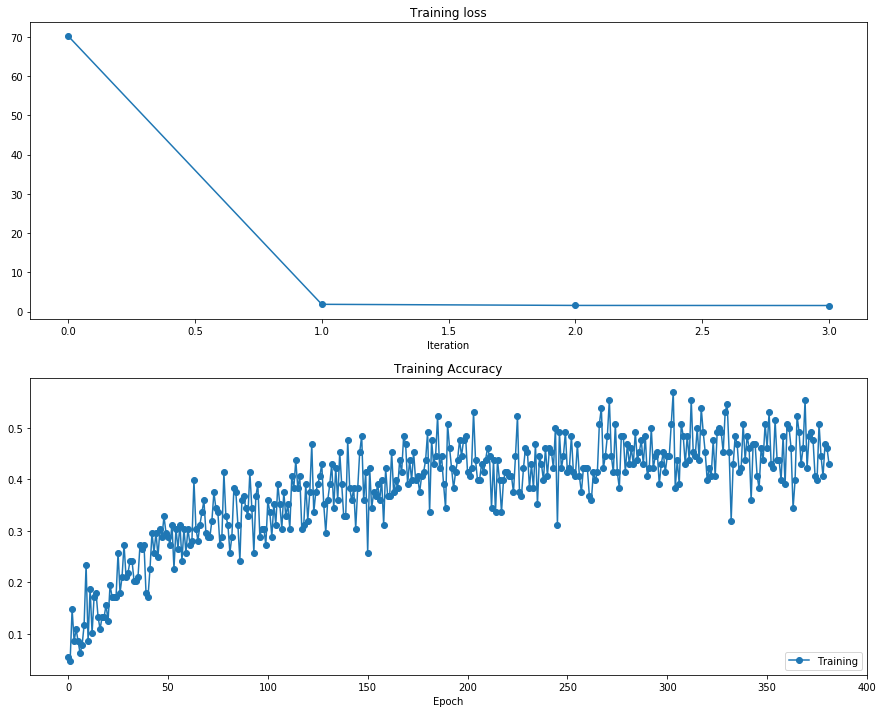

validation for epoch 0
-  epoch 0: validation accuracy = 0.508
train for epoch 1
iteration (400): loss = 1.429, accuracy = 0.492
iteration (450): loss = 1.588, accuracy = 0.398
iteration (500): loss = 1.475, accuracy = 0.469
iteration (550): loss = 1.231, accuracy = 0.586
iteration (600): loss = 1.467, accuracy = 0.477
iteration (650): loss = 1.444, accuracy = 0.508
iteration (700): loss = 1.328, accuracy = 0.516
iteration (750): loss = 1.175, accuracy = 0.555


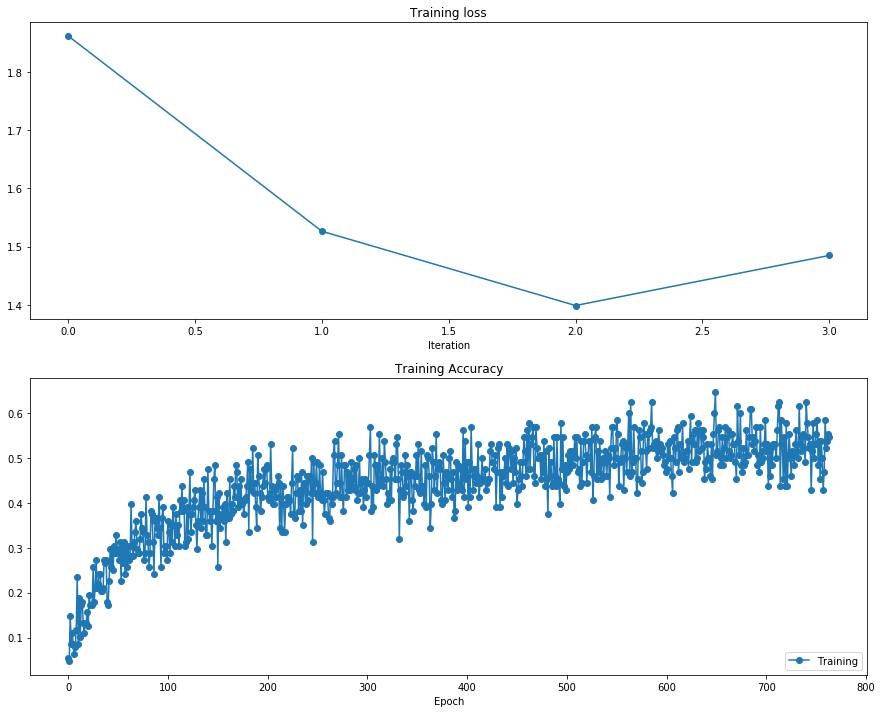

validation for epoch 1
-  epoch 1: validation accuracy = 0.535
train for epoch 2
iteration (800): loss = 1.150, accuracy = 0.586
iteration (850): loss = 1.313, accuracy = 0.508
iteration (900): loss = 1.143, accuracy = 0.641
iteration (950): loss = 1.169, accuracy = 0.586
iteration (1000): loss = 1.208, accuracy = 0.602
iteration (1050): loss = 1.245, accuracy = 0.523
iteration (1100): loss = 1.177, accuracy = 0.555


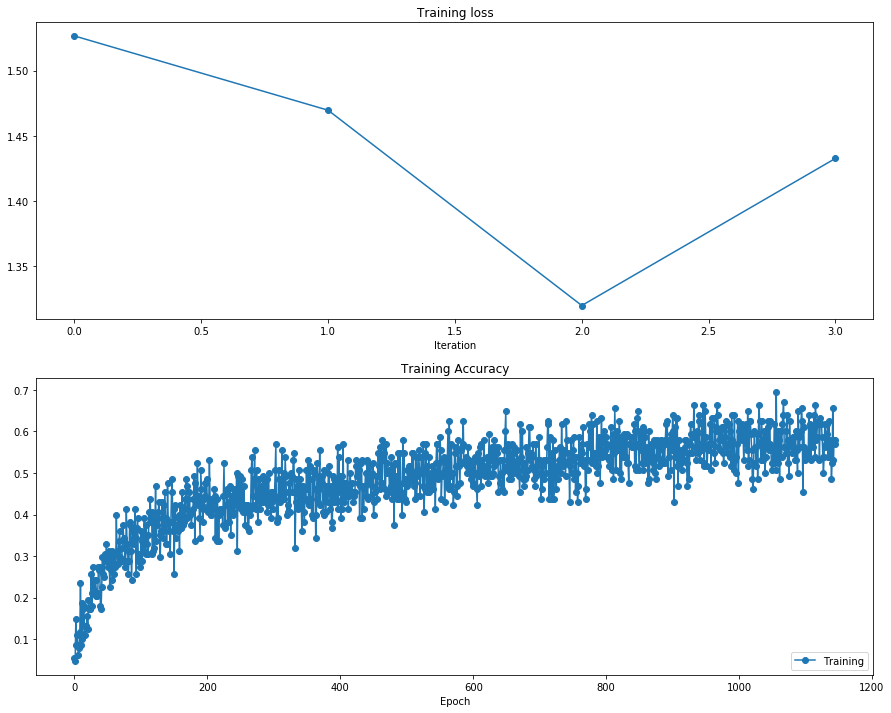

validation for epoch 2
-  epoch 2: validation accuracy = 0.519
train for epoch 3
iteration (1150): loss = 1.181, accuracy = 0.570
iteration (1200): loss = 1.113, accuracy = 0.586
iteration (1250): loss = 1.257, accuracy = 0.578
iteration (1300): loss = 1.152, accuracy = 0.617
iteration (1350): loss = 0.958, accuracy = 0.672
iteration (1400): loss = 1.231, accuracy = 0.641
iteration (1450): loss = 1.045, accuracy = 0.617
iteration (1500): loss = 0.963, accuracy = 0.688


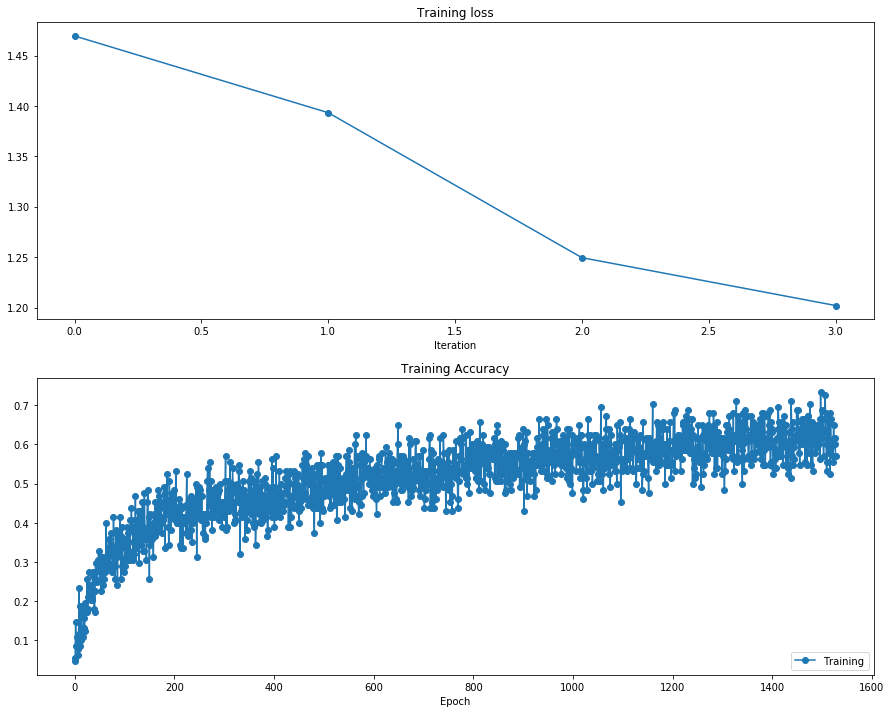

validation for epoch 3
-  epoch 3: validation accuracy = 0.542
train for epoch 4
iteration (1550): loss = 0.903, accuracy = 0.680
iteration (1600): loss = 1.059, accuracy = 0.578
iteration (1650): loss = 0.992, accuracy = 0.656
iteration (1700): loss = 0.979, accuracy = 0.672
iteration (1750): loss = 1.059, accuracy = 0.586
iteration (1800): loss = 1.061, accuracy = 0.617
iteration (1850): loss = 1.048, accuracy = 0.641
iteration (1900): loss = 1.042, accuracy = 0.672


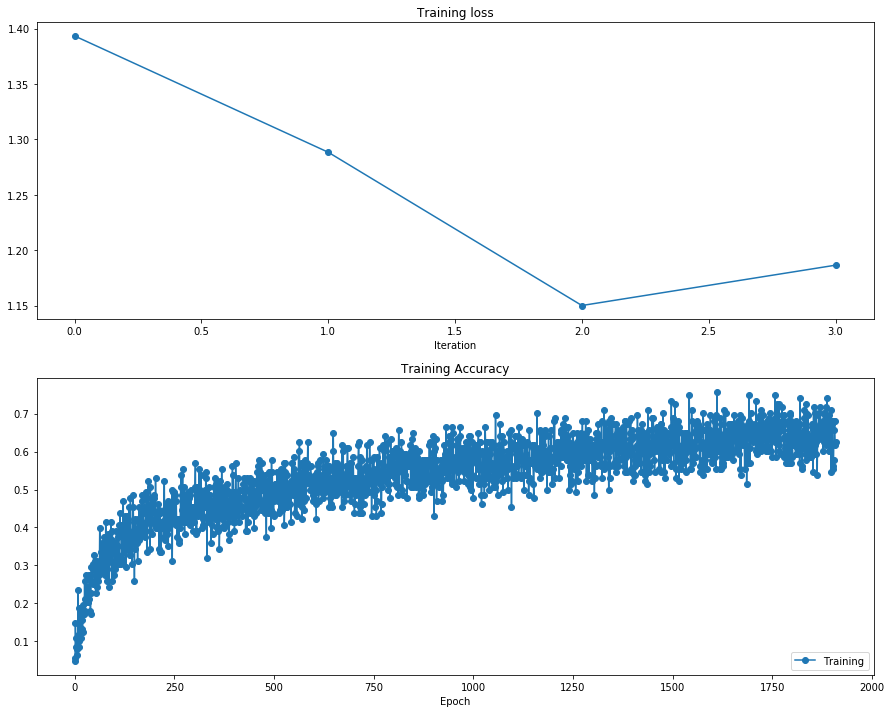

validation for epoch 4
-  epoch 4: validation accuracy = 0.567
***** test accuracy: 0.579
Model saved in lib/tf_models/problem2/csci-599_sample.ckpt


In [8]:
# Clear old computation graphs
tf.reset_default_graph()

# Train our sample model
with tf.Session() as sess:
    with tf.device('/cpu:0'):
        model = BaseModel()
        model.train(sess, X_train, Y_train, X_val, Y_val)
        accuracy = model.evaluate(sess, X_test, Y_test)
        print('***** test accuracy: %.3f' % accuracy)
        saver = tf.train.Saver()
        model_path = saver.save(sess, "lib/tf_models/problem2/csci-599_sample.ckpt")
        print("Model saved in %s" % model_path)

## Question 2-2

Implement your own model. 

You can modify the template code as you want and you can use GPU for fast training.

These are the techniques that you can try:
- Data preprocessing
- Data augmentation
- Dropout
- Batch normalization
- More convolutional layers
- More training epochs
- Learning rate decay
- Any other models and techniqes

Your model should achieve >= 70% accuracy on the test set of CIFAR-10.

If the accuracy of the model reaches to 80% on the test set, you will get 5 extra points.

In [9]:
class YourModel(BaseModel):
    def __init__(self):
        super(YourModel, self).__init__()
        self.num_epoch = 30

    def _model(self):
        print('-' * 5 + '  Your model  ' + '-' * 5)

        print('intput layer: ' + str(self.X.get_shape()))

        with tf.variable_scope('conv1'):
            self.conv1 = conv2d_xavier(self.X, 3, 1, 32)
            self.conv1 = tf.nn.relu(self.conv1)
            self.conv1 = max_pool(self.conv1, 3, 2)
            print('conv1 layer: ' + str(self.conv1.get_shape()))
            
        with tf.variable_scope('conv2'):
            self.conv2 = conv2d_xavier(self.conv1, 3, 1, 64)
            self.conv2 = tf.layers.batch_normalization(self.conv2)
            self.conv2 = tf.nn.relu(self.conv2)
            self.conv2 = max_pool(self.conv2, 3, 2)            
            print('conv2 layer: ' + str(self.conv2.get_shape()))

        with tf.variable_scope('conv3'):
            self.conv3 = conv2d_xavier(self.conv2, 3, 1, 128)
            self.conv3 = tf.layers.batch_normalization(self.conv3)
            self.conv3 = tf.nn.relu(self.conv3)
            self.conv3 = max_pool(self.conv3, 3, 2)            
            print('conv3 layer: ' + str(self.conv3.get_shape()))
            
        with tf.variable_scope('conv4'):
            self.conv4 = conv2d_xavier(self.conv3, 3, 1, 256)
            self.conv4 = tf.layers.batch_normalization(self.conv4)
            self.conv4 = tf.nn.relu(self.conv4) 
            self.conv4 = max_pool(self.conv4, 3, 2)            
            print('conv4 layer: ' + str(self.conv4.get_shape()))

        with tf.variable_scope('conv5'):
            self.conv5 = conv2d_xavier(self.conv4, 3, 1, 512)
            self.conv5 = tf.layers.batch_normalization(self.conv5)
            self.conv5 = tf.nn.relu(self.conv5)
            self.conv5 = max_pool(self.conv5, 3, 2)            
            print('conv5 layer: ' + str(self.conv5.get_shape()))

        self.flat = tf.contrib.layers.flatten(self.conv5)    
        print('flat layer: ' + str(self.flat.get_shape()))

        with tf.variable_scope('fc6'):
            self.fc6 = fully_conn(self.flat, 1024)            
            self.fc6 = tf.nn.dropout(self.fc6, self.keep_prob)
            print('fc6 layer: ' + str(self.fc6.get_shape()))

        with tf.variable_scope('fc7'):
            self.fc7 = fully_conn(self.fc6, 512)            
            self.fc7 = tf.nn.dropout(self.fc7, self.keep_prob)
            print('fc7 layer: ' + str(self.fc7.get_shape()))

        with tf.variable_scope('fc8'):
            self.fc8 = output(self.fc7, 10)             
            print('fc8 layer: ' + str(self.fc8.get_shape()))
        return self.fc8


-----  Your model  -----
intput layer: (?, 32, 32, 3)
conv1 layer: (?, 16, 16, 32)
conv2 layer: (?, 8, 8, 64)
conv3 layer: (?, 4, 4, 128)
conv4 layer: (?, 2, 2, 256)
conv5 layer: (?, 1, 1, 512)
flat layer: (?, 512)
fc6 layer: (?, 1024)
fc7 layer: (?, 512)
fc8 layer: (?, 10)
-----  Start training  -----
train for epoch 0
iteration (0): loss = 2.307, accuracy = 0.102
iteration (50): loss = 2.262, accuracy = 0.141
iteration (100): loss = 1.900, accuracy = 0.250
iteration (150): loss = 1.712, accuracy = 0.273
iteration (200): loss = 1.559, accuracy = 0.430
iteration (250): loss = 1.548, accuracy = 0.445
iteration (300): loss = 1.421, accuracy = 0.461
iteration (350): loss = 1.450, accuracy = 0.445


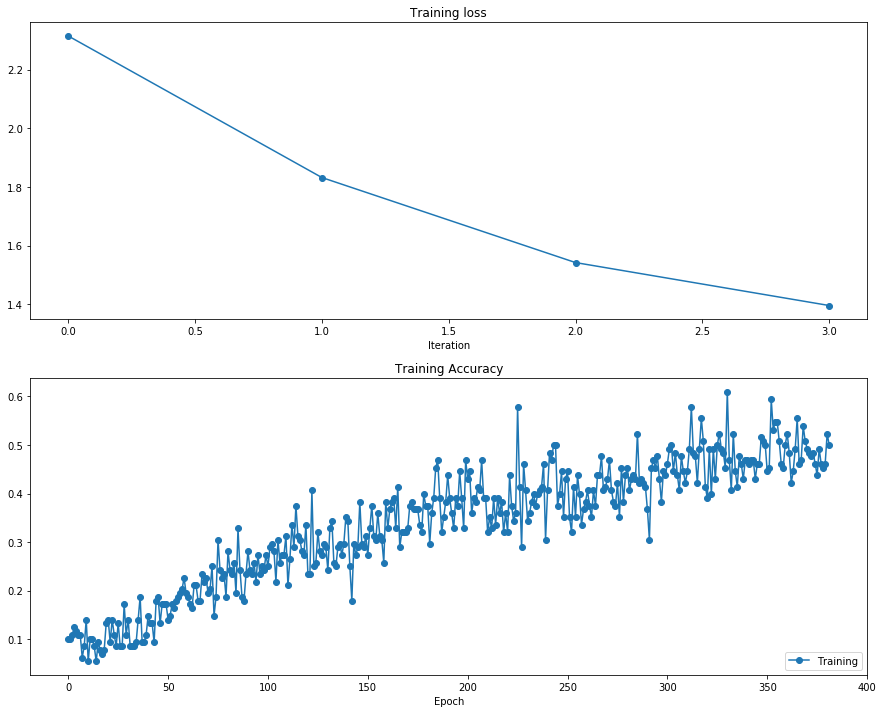

validation for epoch 0
-  epoch 0: validation accuracy = 0.502
train for epoch 1
iteration (400): loss = 1.288, accuracy = 0.523
iteration (450): loss = 1.439, accuracy = 0.508
iteration (500): loss = 1.329, accuracy = 0.531
iteration (550): loss = 1.068, accuracy = 0.641
iteration (600): loss = 1.288, accuracy = 0.562
iteration (650): loss = 1.226, accuracy = 0.578
iteration (700): loss = 1.061, accuracy = 0.609
iteration (750): loss = 0.981, accuracy = 0.648


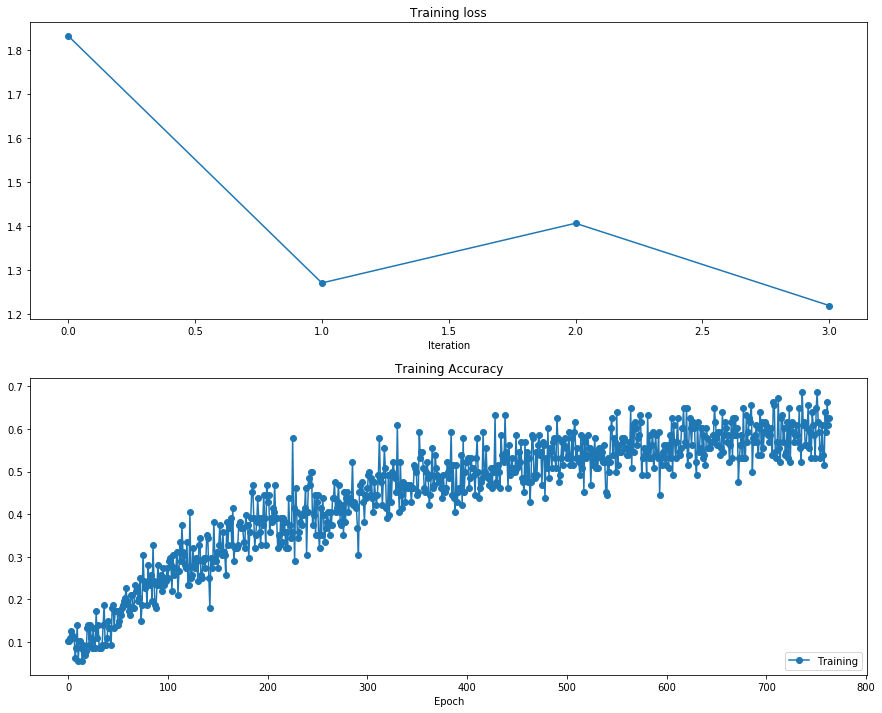

validation for epoch 1
-  epoch 1: validation accuracy = 0.606
train for epoch 2
iteration (800): loss = 1.059, accuracy = 0.602
iteration (850): loss = 1.151, accuracy = 0.594
iteration (900): loss = 1.221, accuracy = 0.594
iteration (950): loss = 0.806, accuracy = 0.727
iteration (1000): loss = 0.830, accuracy = 0.688
iteration (1050): loss = 0.900, accuracy = 0.688
iteration (1100): loss = 0.829, accuracy = 0.711


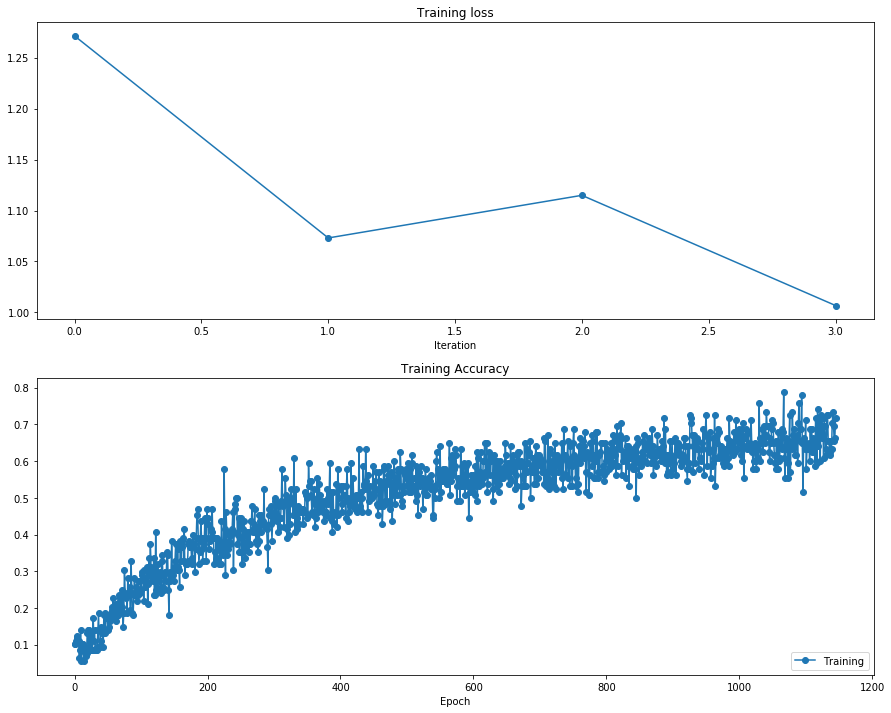

validation for epoch 2
-  epoch 2: validation accuracy = 0.665
train for epoch 3
iteration (1150): loss = 0.804, accuracy = 0.719
iteration (1200): loss = 0.749, accuracy = 0.703
iteration (1250): loss = 0.915, accuracy = 0.664
iteration (1300): loss = 0.956, accuracy = 0.664
iteration (1350): loss = 0.794, accuracy = 0.727
iteration (1400): loss = 0.741, accuracy = 0.781
iteration (1450): loss = 0.837, accuracy = 0.695
iteration (1500): loss = 0.630, accuracy = 0.758


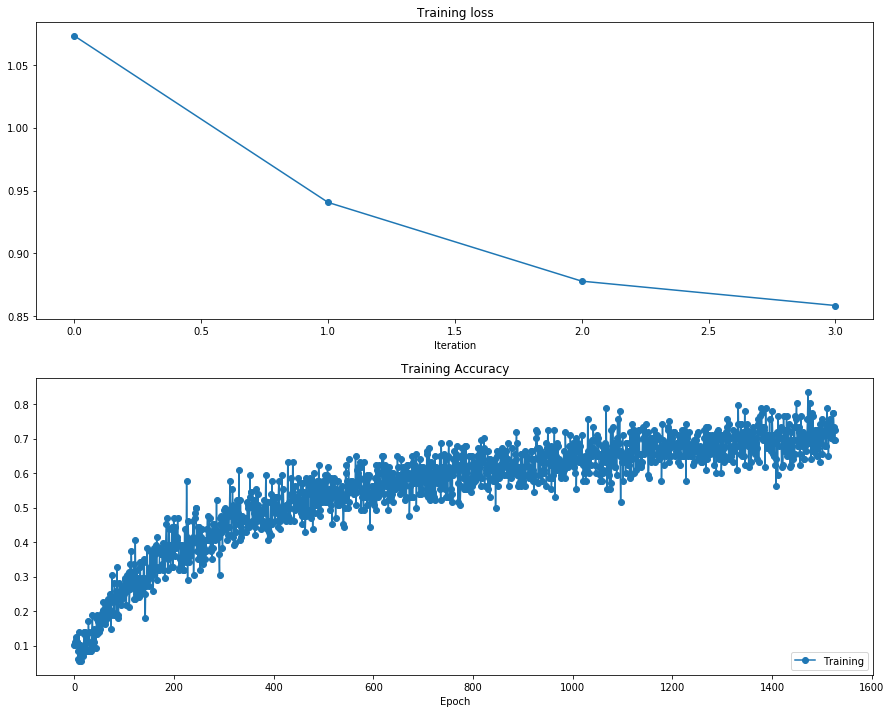

validation for epoch 3
-  epoch 3: validation accuracy = 0.700
train for epoch 4
iteration (1550): loss = 0.739, accuracy = 0.766
iteration (1600): loss = 0.745, accuracy = 0.766
iteration (1650): loss = 0.886, accuracy = 0.688
iteration (1700): loss = 0.887, accuracy = 0.664
iteration (1750): loss = 0.872, accuracy = 0.688
iteration (1800): loss = 0.809, accuracy = 0.719
iteration (1850): loss = 0.670, accuracy = 0.789
iteration (1900): loss = 0.709, accuracy = 0.758


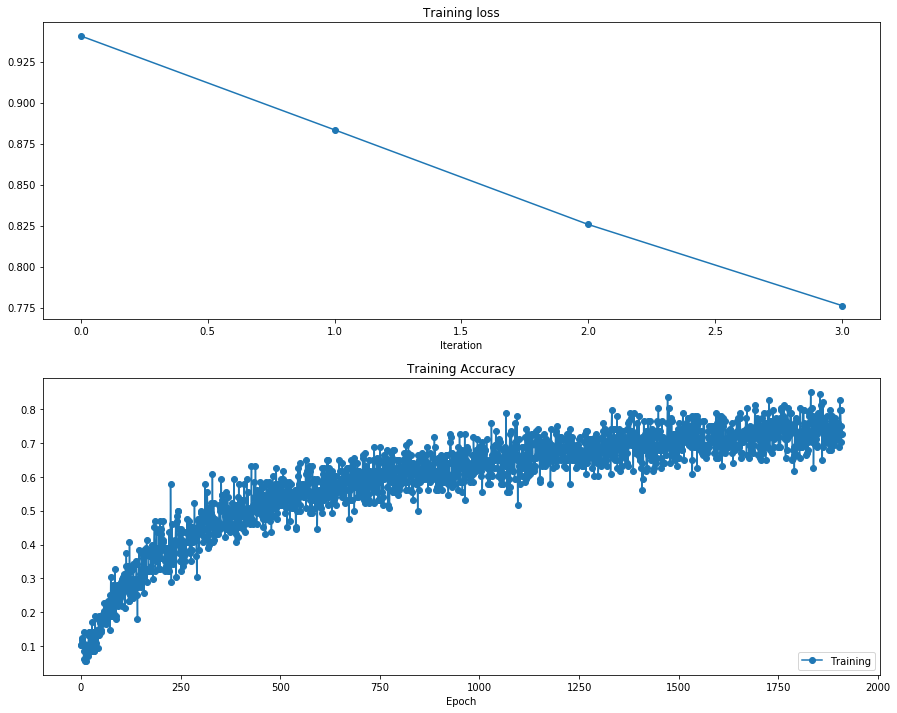

validation for epoch 4
-  epoch 4: validation accuracy = 0.723
train for epoch 5
iteration (1950): loss = 0.788, accuracy = 0.734
iteration (2000): loss = 0.765, accuracy = 0.711
iteration (2050): loss = 0.659, accuracy = 0.789
iteration (2100): loss = 0.773, accuracy = 0.711
iteration (2150): loss = 0.884, accuracy = 0.703
iteration (2200): loss = 0.756, accuracy = 0.703
iteration (2250): loss = 0.565, accuracy = 0.805


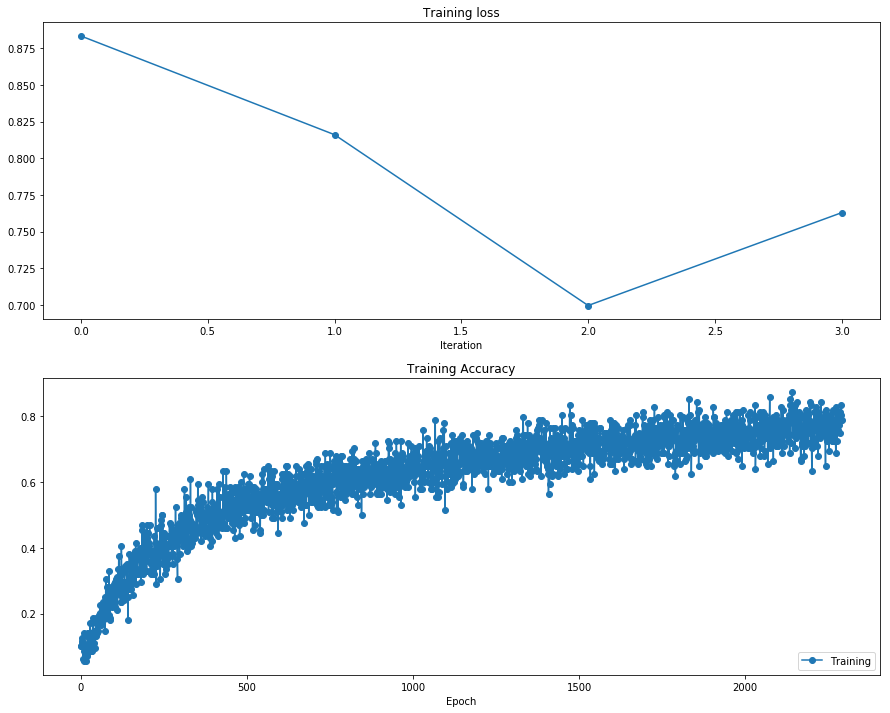

validation for epoch 5
-  epoch 5: validation accuracy = 0.732
train for epoch 6
iteration (2300): loss = 0.829, accuracy = 0.719
iteration (2350): loss = 0.626, accuracy = 0.805
iteration (2400): loss = 0.753, accuracy = 0.727
iteration (2450): loss = 0.810, accuracy = 0.719
iteration (2500): loss = 0.691, accuracy = 0.820
iteration (2550): loss = 0.673, accuracy = 0.758
iteration (2600): loss = 0.541, accuracy = 0.797
iteration (2650): loss = 0.552, accuracy = 0.820


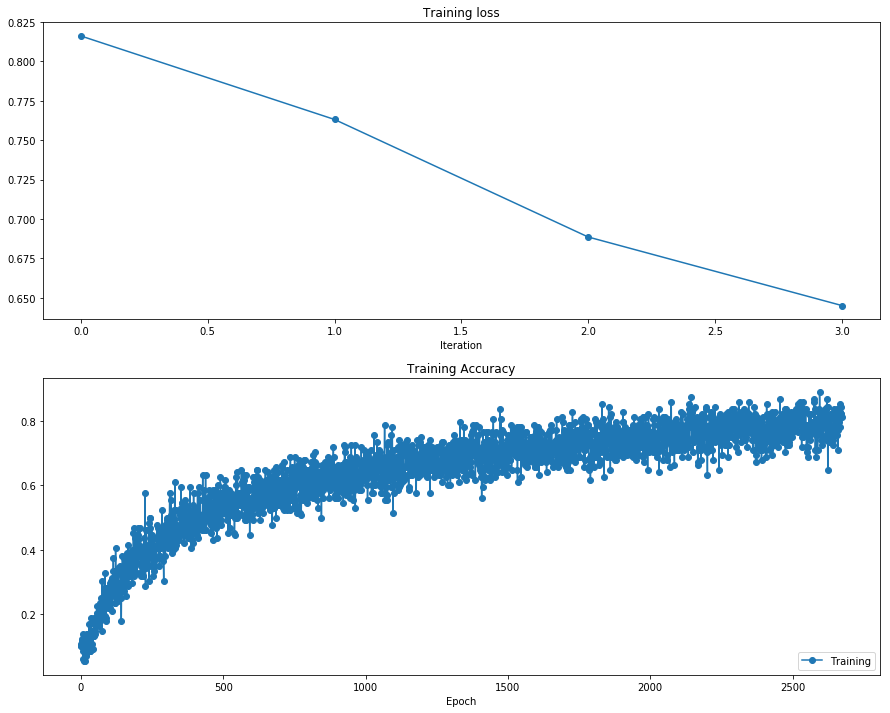

validation for epoch 6
-  epoch 6: validation accuracy = 0.735
train for epoch 7
iteration (2700): loss = 0.706, accuracy = 0.758
iteration (2750): loss = 0.807, accuracy = 0.734
iteration (2800): loss = 0.570, accuracy = 0.812
iteration (2850): loss = 0.508, accuracy = 0.773
iteration (2900): loss = 0.461, accuracy = 0.797
iteration (2950): loss = 0.519, accuracy = 0.828
iteration (3000): loss = 0.432, accuracy = 0.898
iteration (3050): loss = 0.455, accuracy = 0.844


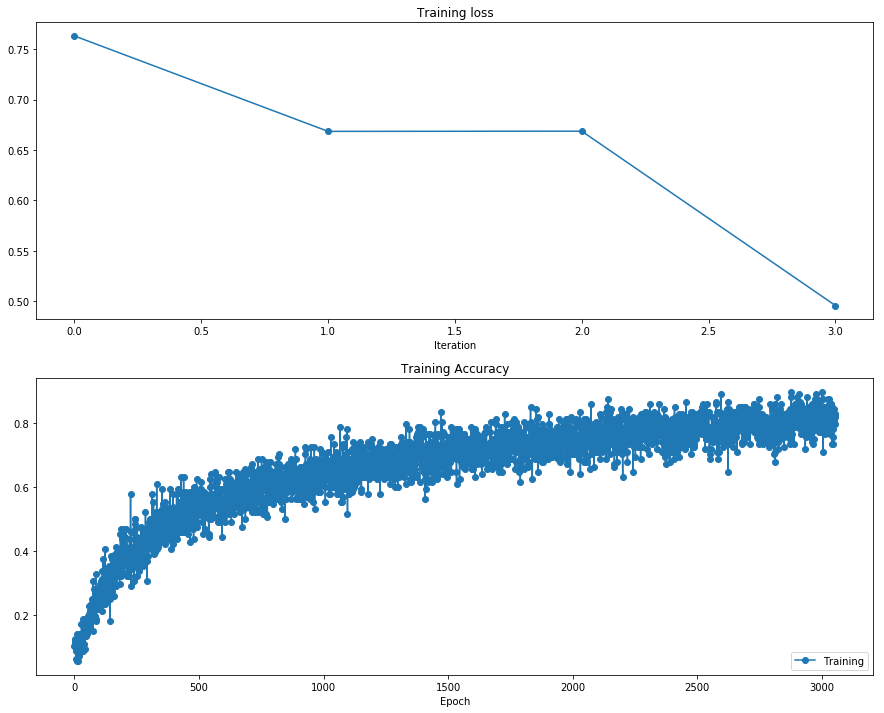

validation for epoch 7
-  epoch 7: validation accuracy = 0.730
train for epoch 8
iteration (3100): loss = 0.480, accuracy = 0.852
iteration (3150): loss = 0.613, accuracy = 0.781
iteration (3200): loss = 0.467, accuracy = 0.867
iteration (3250): loss = 0.576, accuracy = 0.789
iteration (3300): loss = 0.504, accuracy = 0.828
iteration (3350): loss = 0.502, accuracy = 0.820
iteration (3400): loss = 0.451, accuracy = 0.812


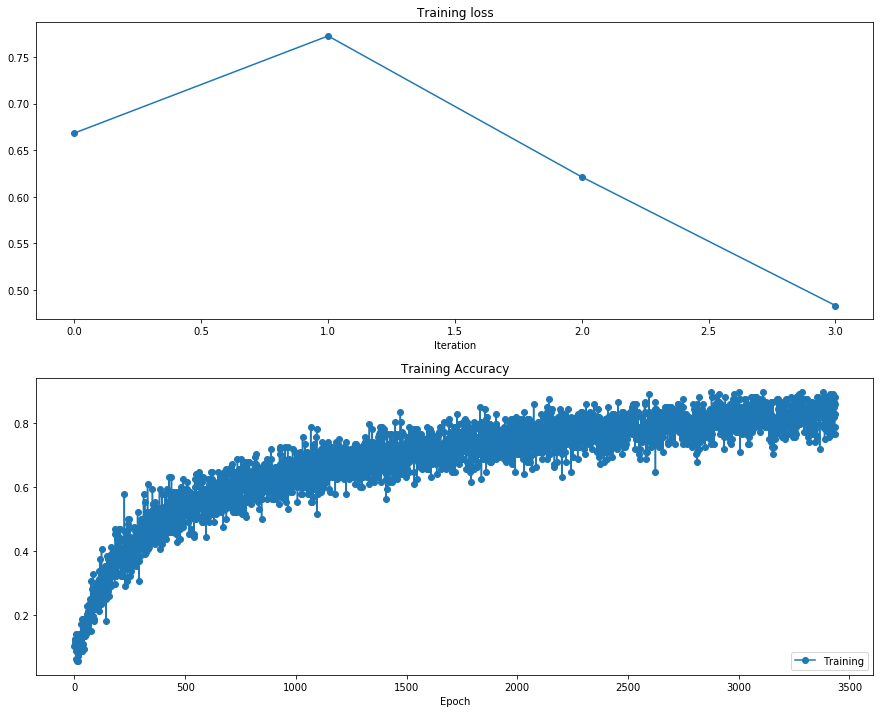

validation for epoch 8
-  epoch 8: validation accuracy = 0.713
train for epoch 9
iteration (3450): loss = 0.385, accuracy = 0.883
iteration (3500): loss = 0.498, accuracy = 0.805
iteration (3550): loss = 0.712, accuracy = 0.758
iteration (3600): loss = 0.350, accuracy = 0.883
iteration (3650): loss = 0.505, accuracy = 0.852
iteration (3700): loss = 0.650, accuracy = 0.734
iteration (3750): loss = 0.474, accuracy = 0.820
iteration (3800): loss = 0.350, accuracy = 0.883


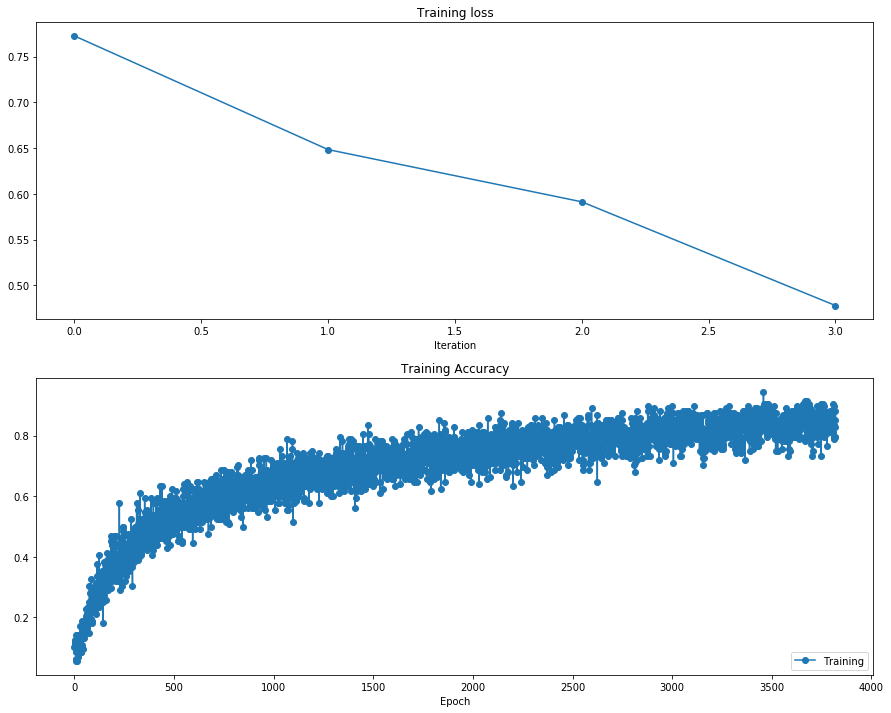

validation for epoch 9
-  epoch 9: validation accuracy = 0.747
train for epoch 10
iteration (3850): loss = 0.393, accuracy = 0.852
iteration (3900): loss = 0.348, accuracy = 0.875
iteration (3950): loss = 0.463, accuracy = 0.828
iteration (4000): loss = 0.457, accuracy = 0.844
iteration (4050): loss = 0.208, accuracy = 0.914
iteration (4100): loss = 0.378, accuracy = 0.867
iteration (4150): loss = 0.264, accuracy = 0.898
iteration (4200): loss = 0.606, accuracy = 0.797


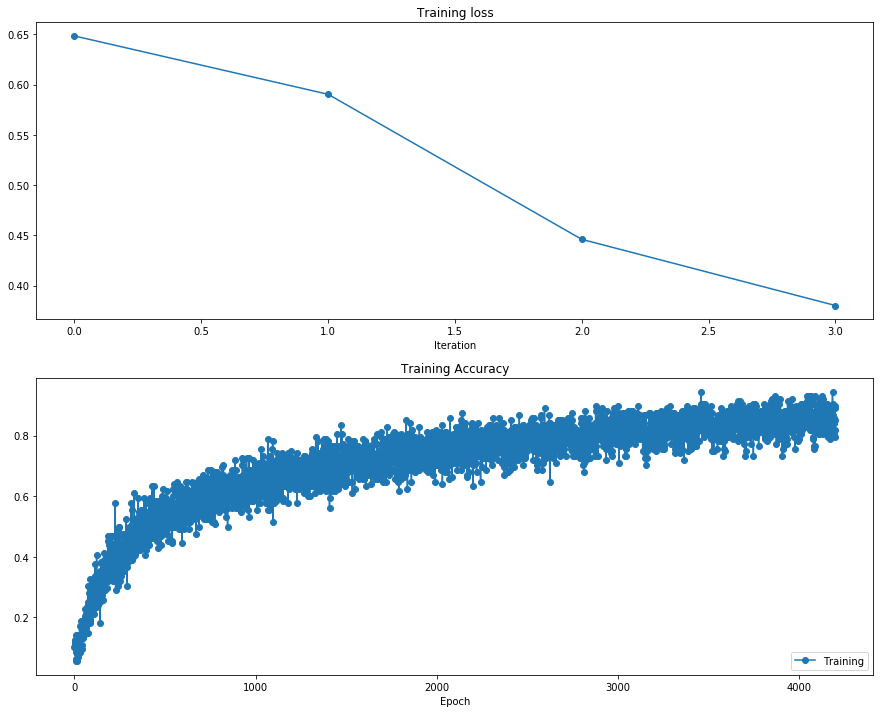

validation for epoch 10
-  epoch 10: validation accuracy = 0.752
train for epoch 11
iteration (4250): loss = 0.315, accuracy = 0.883
iteration (4300): loss = 0.419, accuracy = 0.859
iteration (4350): loss = 0.359, accuracy = 0.852
iteration (4400): loss = 0.342, accuracy = 0.898
iteration (4450): loss = 0.404, accuracy = 0.875
iteration (4500): loss = 0.261, accuracy = 0.906
iteration (4550): loss = 0.334, accuracy = 0.883


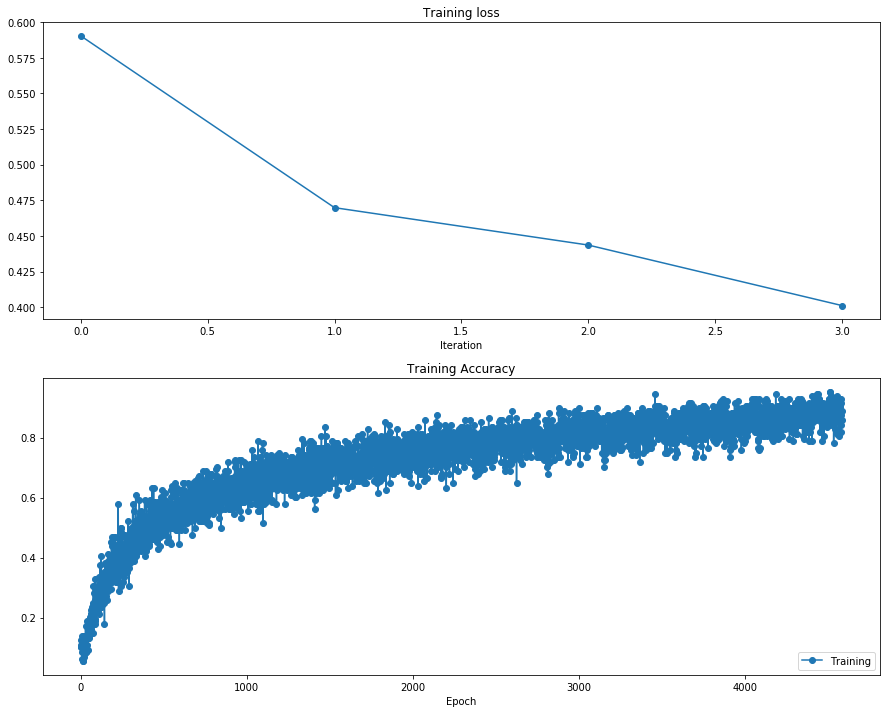

validation for epoch 11
-  epoch 11: validation accuracy = 0.747
train for epoch 12
iteration (4600): loss = 0.257, accuracy = 0.930
iteration (4650): loss = 0.438, accuracy = 0.852
iteration (4700): loss = 0.277, accuracy = 0.875
iteration (4750): loss = 0.365, accuracy = 0.875
iteration (4800): loss = 0.280, accuracy = 0.875
iteration (4850): loss = 0.423, accuracy = 0.875
iteration (4900): loss = 0.425, accuracy = 0.875
iteration (4950): loss = 0.319, accuracy = 0.867


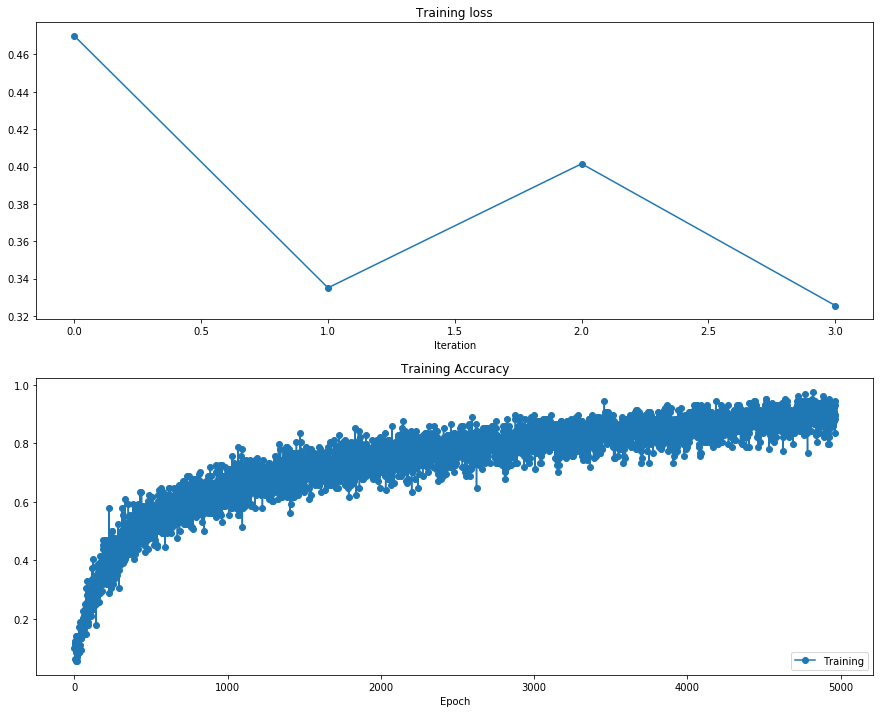

validation for epoch 12
-  epoch 12: validation accuracy = 0.744
train for epoch 13
iteration (5000): loss = 0.163, accuracy = 0.945
iteration (5050): loss = 0.288, accuracy = 0.914
iteration (5100): loss = 0.269, accuracy = 0.898
iteration (5150): loss = 0.294, accuracy = 0.883
iteration (5200): loss = 0.288, accuracy = 0.867
iteration (5250): loss = 0.457, accuracy = 0.859
iteration (5300): loss = 0.179, accuracy = 0.945


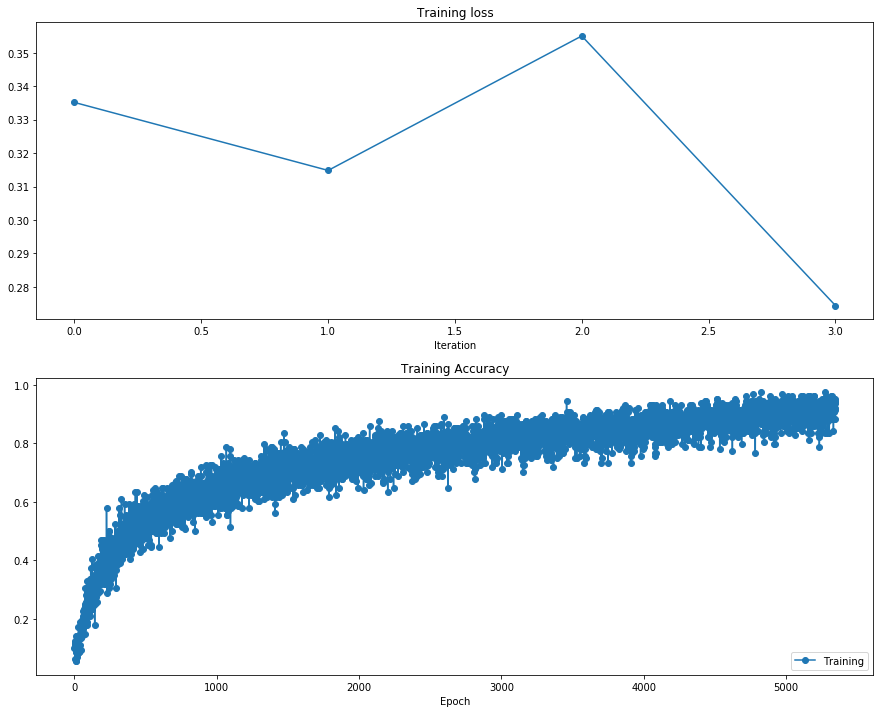

validation for epoch 13
-  epoch 13: validation accuracy = 0.744
train for epoch 14
iteration (5350): loss = 0.316, accuracy = 0.906
iteration (5400): loss = 0.285, accuracy = 0.914
iteration (5450): loss = 0.205, accuracy = 0.938
iteration (5500): loss = 0.339, accuracy = 0.898
iteration (5550): loss = 0.356, accuracy = 0.852
iteration (5600): loss = 0.261, accuracy = 0.922
iteration (5650): loss = 0.206, accuracy = 0.953
iteration (5700): loss = 0.255, accuracy = 0.898


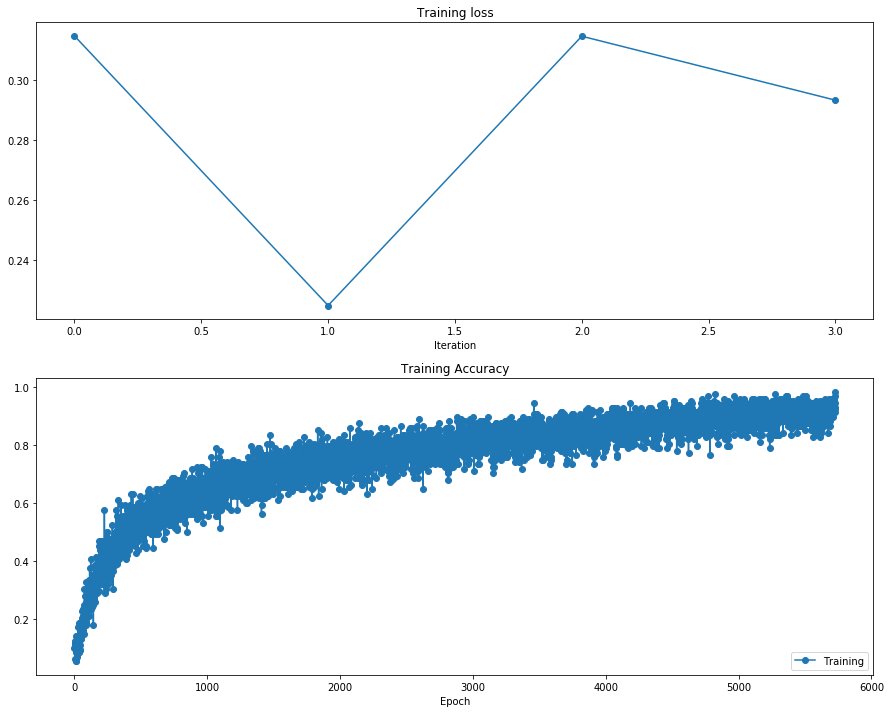

validation for epoch 14
-  epoch 14: validation accuracy = 0.758
train for epoch 15
iteration (5750): loss = 0.044, accuracy = 0.984
iteration (5800): loss = 0.220, accuracy = 0.922
iteration (5850): loss = 0.264, accuracy = 0.922
iteration (5900): loss = 0.311, accuracy = 0.891
iteration (5950): loss = 0.186, accuracy = 0.930
iteration (6000): loss = 0.216, accuracy = 0.938
iteration (6050): loss = 0.171, accuracy = 0.945
iteration (6100): loss = 0.151, accuracy = 0.945


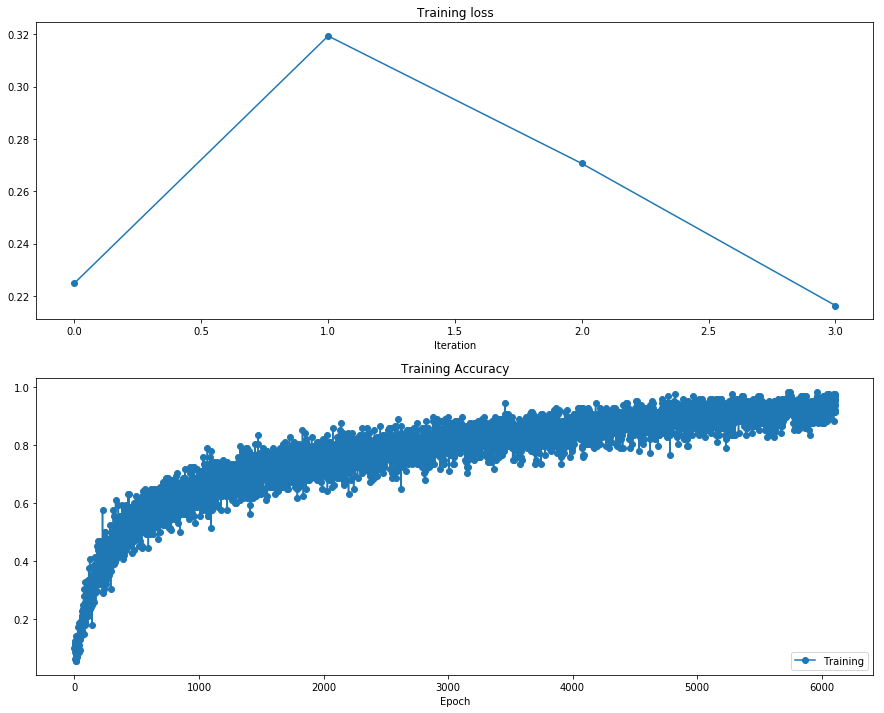

validation for epoch 15
-  epoch 15: validation accuracy = 0.720
train for epoch 16
iteration (6150): loss = 0.225, accuracy = 0.945
iteration (6200): loss = 0.253, accuracy = 0.914
iteration (6250): loss = 0.268, accuracy = 0.930
iteration (6300): loss = 0.218, accuracy = 0.914
iteration (6350): loss = 0.165, accuracy = 0.953
iteration (6400): loss = 0.193, accuracy = 0.953
iteration (6450): loss = 0.144, accuracy = 0.945


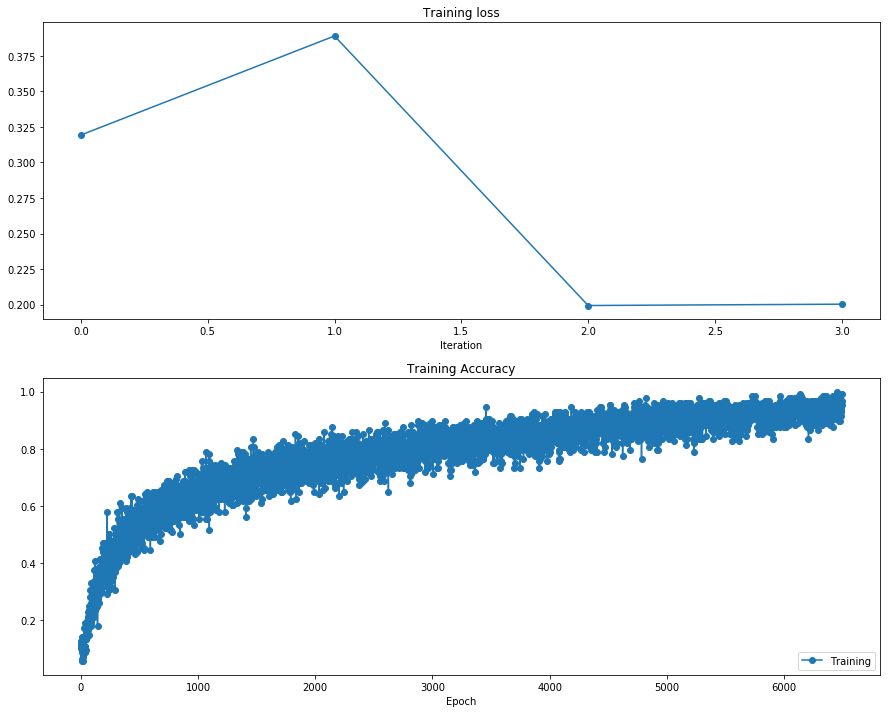

validation for epoch 16
-  epoch 16: validation accuracy = 0.740
train for epoch 17
iteration (6500): loss = 0.137, accuracy = 0.969
iteration (6550): loss = 0.137, accuracy = 0.945
iteration (6600): loss = 0.354, accuracy = 0.891
iteration (6650): loss = 0.080, accuracy = 0.969
iteration (6700): loss = 0.117, accuracy = 0.953
iteration (6750): loss = 0.250, accuracy = 0.930
iteration (6800): loss = 0.100, accuracy = 0.953
iteration (6850): loss = 0.088, accuracy = 0.961


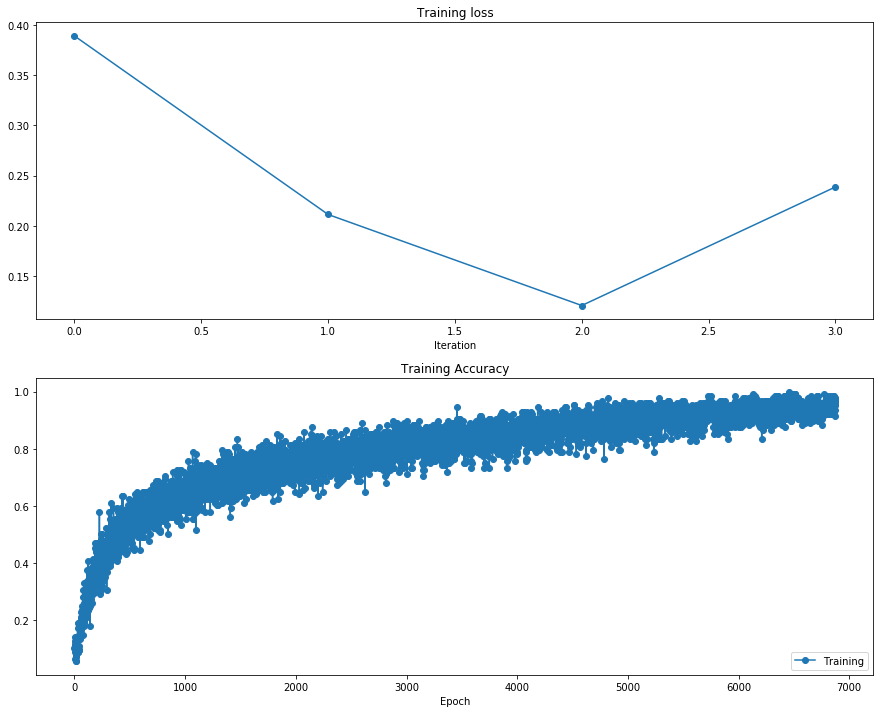

validation for epoch 17
-  epoch 17: validation accuracy = 0.750
train for epoch 18
iteration (6900): loss = 0.212, accuracy = 0.922
iteration (6950): loss = 0.092, accuracy = 0.961
iteration (7000): loss = 0.163, accuracy = 0.953
iteration (7050): loss = 0.180, accuracy = 0.930
iteration (7100): loss = 0.127, accuracy = 0.961
iteration (7150): loss = 0.128, accuracy = 0.977
iteration (7200): loss = 0.187, accuracy = 0.945
iteration (7250): loss = 0.190, accuracy = 0.930


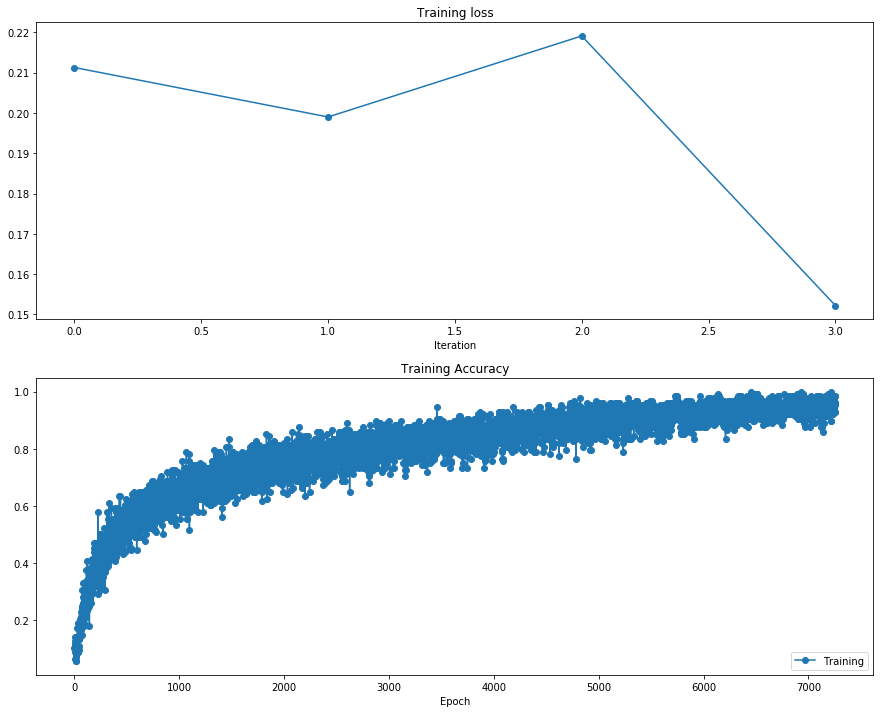

validation for epoch 18
-  epoch 18: validation accuracy = 0.733
train for epoch 19
iteration (7300): loss = 0.134, accuracy = 0.930
iteration (7350): loss = 0.340, accuracy = 0.922
iteration (7400): loss = 0.092, accuracy = 0.984
iteration (7450): loss = 0.169, accuracy = 0.930
iteration (7500): loss = 0.099, accuracy = 0.969
iteration (7550): loss = 0.106, accuracy = 0.977
iteration (7600): loss = 0.153, accuracy = 0.961


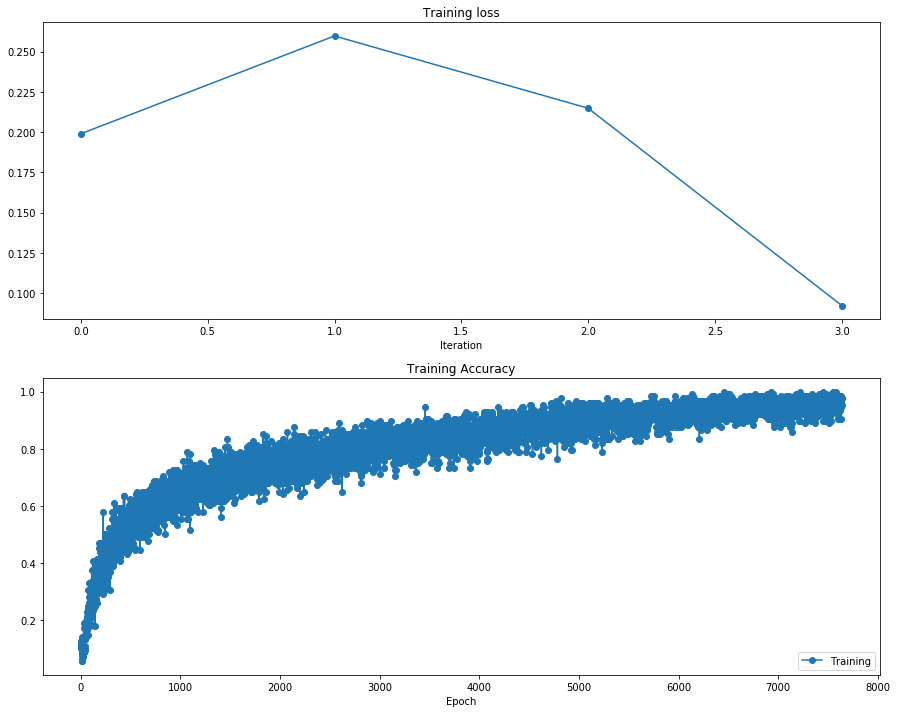

validation for epoch 19
-  epoch 19: validation accuracy = 0.733
train for epoch 20
iteration (7650): loss = 0.082, accuracy = 0.992
iteration (7700): loss = 0.129, accuracy = 0.969
iteration (7750): loss = 0.147, accuracy = 0.961
iteration (7800): loss = 0.061, accuracy = 0.984
iteration (7850): loss = 0.076, accuracy = 0.984
iteration (7900): loss = 0.131, accuracy = 0.961
iteration (7950): loss = 0.152, accuracy = 0.938
iteration (8000): loss = 0.092, accuracy = 0.969


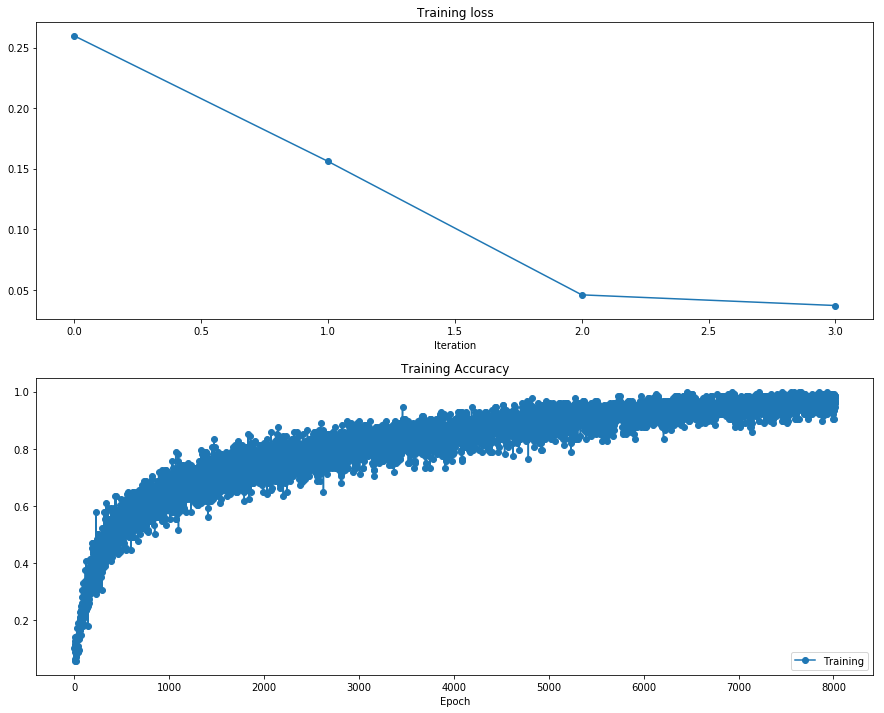

validation for epoch 20
-  epoch 20: validation accuracy = 0.746
train for epoch 21
iteration (8050): loss = 0.051, accuracy = 0.984
iteration (8100): loss = 0.084, accuracy = 0.969
iteration (8150): loss = 0.032, accuracy = 0.992
iteration (8200): loss = 0.061, accuracy = 0.984
iteration (8250): loss = 0.063, accuracy = 0.969
iteration (8300): loss = 0.021, accuracy = 1.000
iteration (8350): loss = 0.072, accuracy = 0.969
iteration (8400): loss = 0.090, accuracy = 0.953


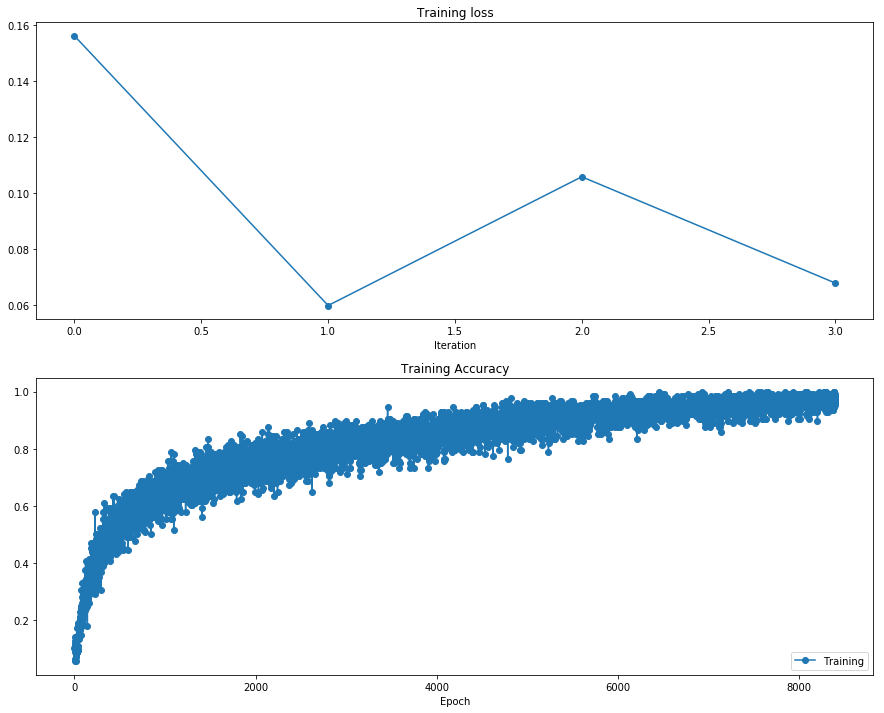

validation for epoch 21
-  epoch 21: validation accuracy = 0.732
train for epoch 22
iteration (8450): loss = 0.026, accuracy = 0.992
iteration (8500): loss = 0.108, accuracy = 0.977
iteration (8550): loss = 0.035, accuracy = 0.984
iteration (8600): loss = 0.120, accuracy = 0.961
iteration (8650): loss = 0.055, accuracy = 0.984
iteration (8700): loss = 0.043, accuracy = 1.000
iteration (8750): loss = 0.094, accuracy = 0.961


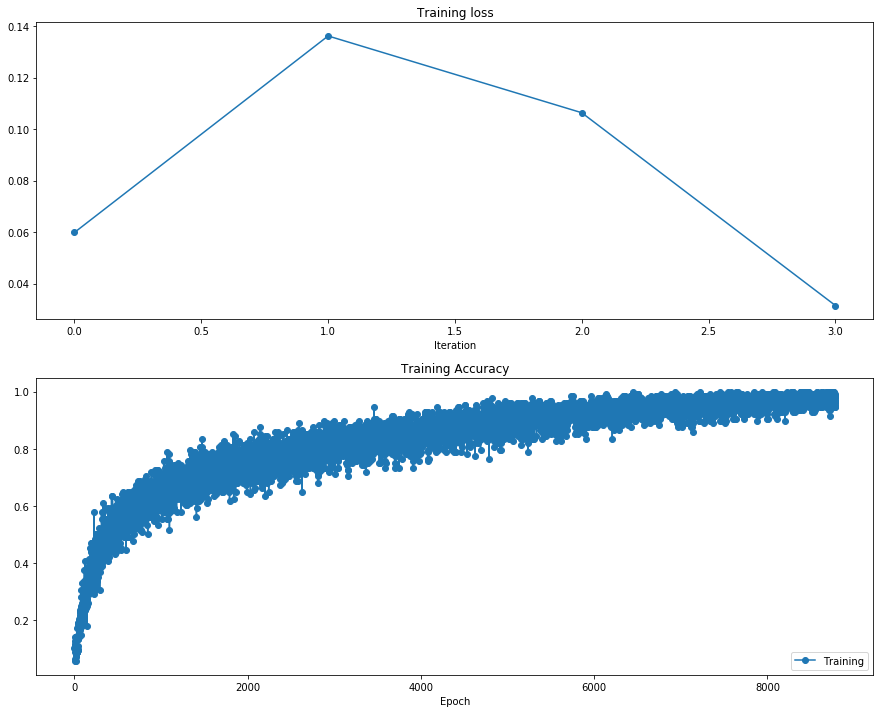

validation for epoch 22
-  epoch 22: validation accuracy = 0.753
train for epoch 23
iteration (8800): loss = 0.058, accuracy = 0.984
iteration (8850): loss = 0.082, accuracy = 0.969
iteration (8900): loss = 0.125, accuracy = 0.969
iteration (8950): loss = 0.084, accuracy = 0.961
iteration (9000): loss = 0.081, accuracy = 0.961
iteration (9050): loss = 0.049, accuracy = 0.977
iteration (9100): loss = 0.035, accuracy = 0.984
iteration (9150): loss = 0.032, accuracy = 0.984


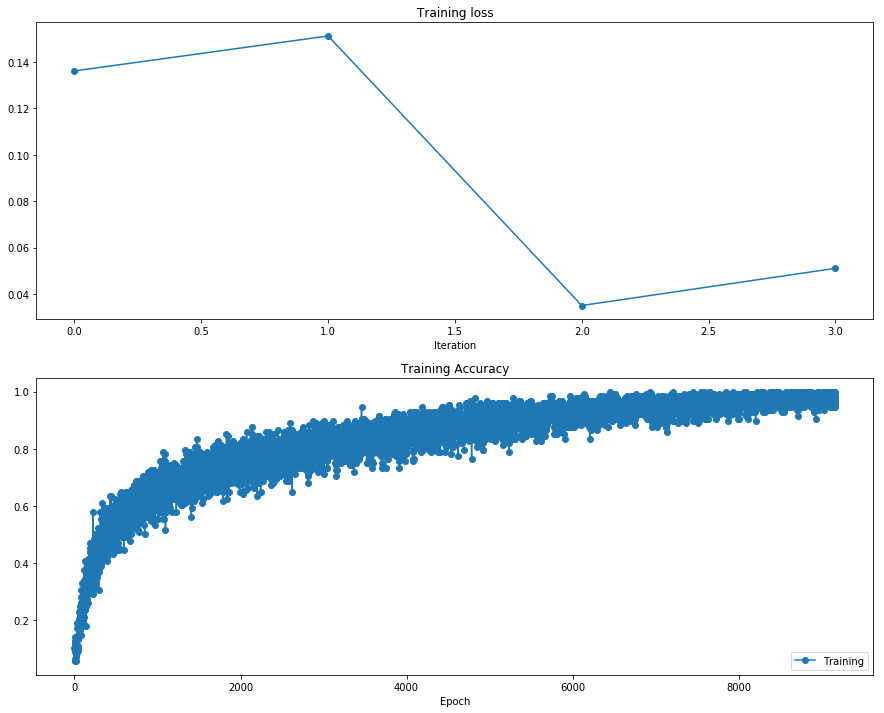

validation for epoch 23
-  epoch 23: validation accuracy = 0.735
train for epoch 24
iteration (9200): loss = 0.091, accuracy = 0.977
iteration (9250): loss = 0.044, accuracy = 0.977
iteration (9300): loss = 0.025, accuracy = 1.000
iteration (9350): loss = 0.030, accuracy = 1.000
iteration (9400): loss = 0.056, accuracy = 0.969
iteration (9450): loss = 0.038, accuracy = 0.992
iteration (9500): loss = 0.123, accuracy = 0.961


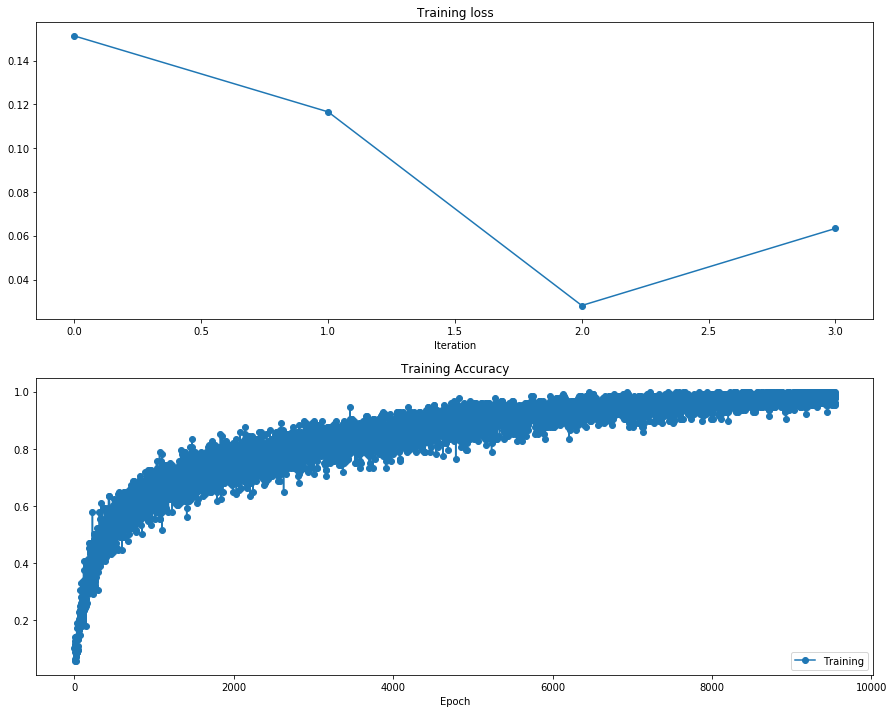

validation for epoch 24
-  epoch 24: validation accuracy = 0.750
train for epoch 25
iteration (9550): loss = 0.046, accuracy = 0.984
iteration (9600): loss = 0.014, accuracy = 1.000
iteration (9650): loss = 0.054, accuracy = 0.977
iteration (9700): loss = 0.037, accuracy = 0.984
iteration (9750): loss = 0.057, accuracy = 0.984
iteration (9800): loss = 0.011, accuracy = 1.000
iteration (9850): loss = 0.013, accuracy = 1.000
iteration (9900): loss = 0.016, accuracy = 1.000


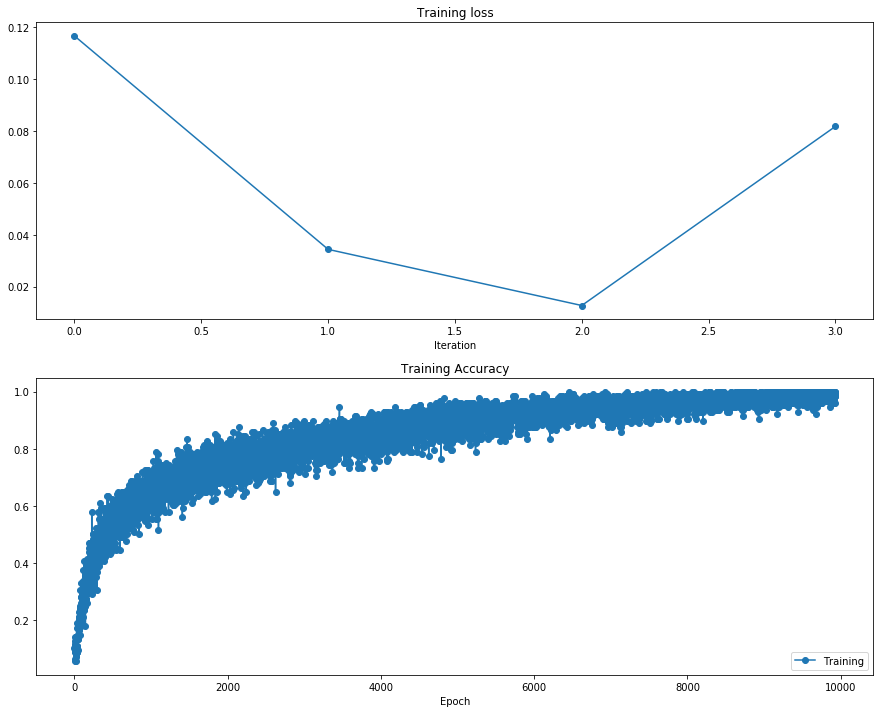

validation for epoch 25
-  epoch 25: validation accuracy = 0.722
train for epoch 26
iteration (9950): loss = 0.040, accuracy = 0.984
iteration (10000): loss = 0.030, accuracy = 0.984
iteration (10050): loss = 0.037, accuracy = 0.992
iteration (10100): loss = 0.111, accuracy = 0.969
iteration (10150): loss = 0.064, accuracy = 0.977
iteration (10200): loss = 0.052, accuracy = 0.977
iteration (10250): loss = 0.035, accuracy = 0.984
iteration (10300): loss = 0.024, accuracy = 0.992


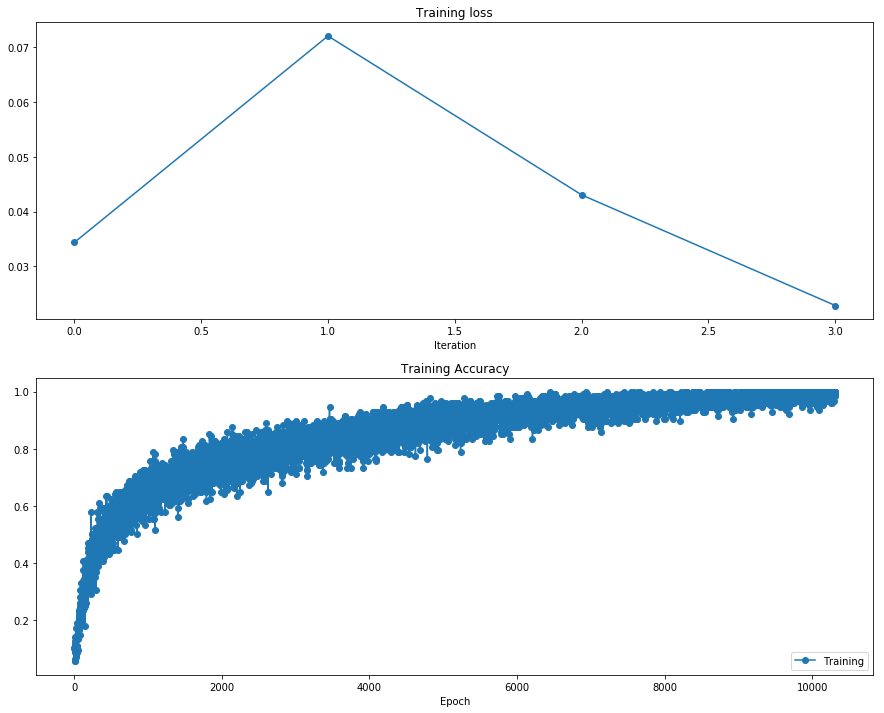

validation for epoch 26
-  epoch 26: validation accuracy = 0.750
train for epoch 27
iteration (10350): loss = 0.062, accuracy = 0.984
iteration (10400): loss = 0.040, accuracy = 0.984
iteration (10450): loss = 0.016, accuracy = 1.000
iteration (10500): loss = 0.080, accuracy = 0.984
iteration (10550): loss = 0.032, accuracy = 0.992
iteration (10600): loss = 0.037, accuracy = 0.992
iteration (10650): loss = 0.062, accuracy = 0.977


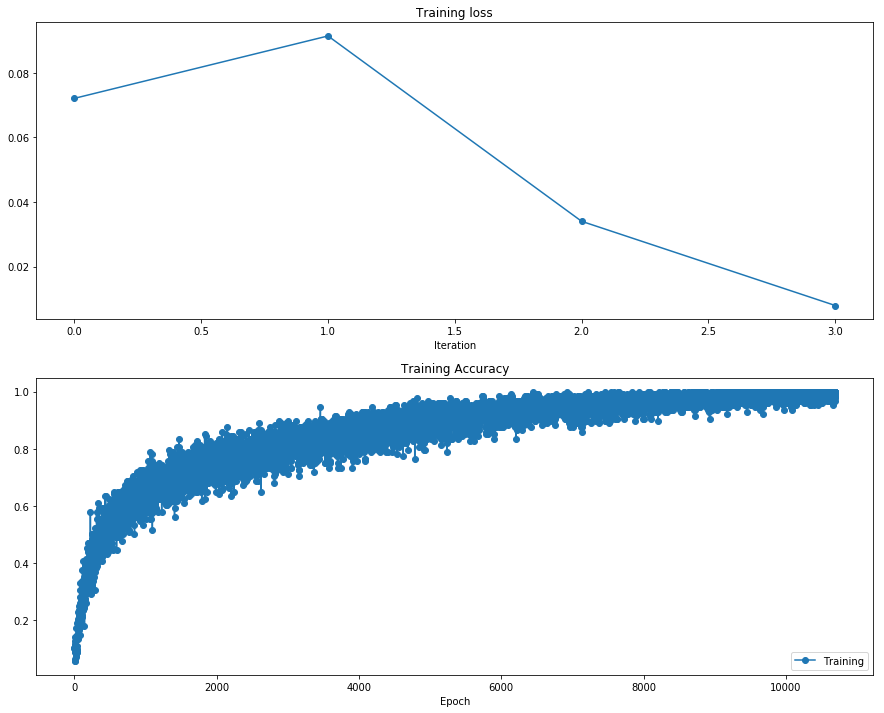

validation for epoch 27
-  epoch 27: validation accuracy = 0.749
train for epoch 28
iteration (10700): loss = 0.034, accuracy = 0.984
iteration (10750): loss = 0.039, accuracy = 0.992
iteration (10800): loss = 0.026, accuracy = 0.984
iteration (10850): loss = 0.017, accuracy = 1.000
iteration (10900): loss = 0.077, accuracy = 0.953
iteration (10950): loss = 0.011, accuracy = 1.000
iteration (11000): loss = 0.021, accuracy = 0.992
iteration (11050): loss = 0.023, accuracy = 0.992


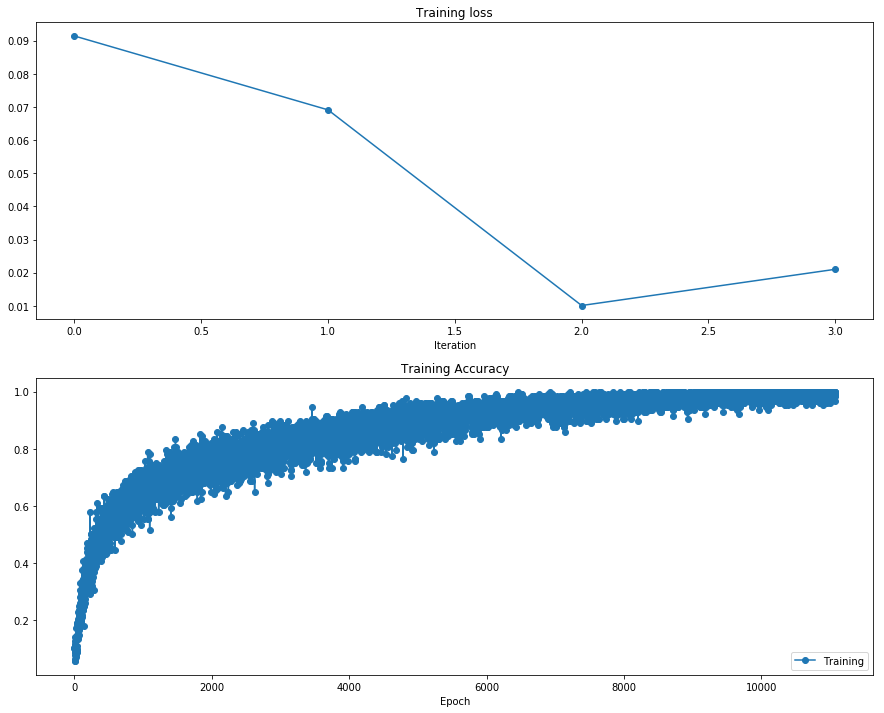

validation for epoch 28
-  epoch 28: validation accuracy = 0.765
train for epoch 29
iteration (11100): loss = 0.058, accuracy = 0.984
iteration (11150): loss = 0.006, accuracy = 1.000
iteration (11200): loss = 0.019, accuracy = 0.992
iteration (11250): loss = 0.021, accuracy = 0.992
iteration (11300): loss = 0.018, accuracy = 1.000
iteration (11350): loss = 0.009, accuracy = 1.000
iteration (11400): loss = 0.024, accuracy = 0.992
iteration (11450): loss = 0.004, accuracy = 1.000


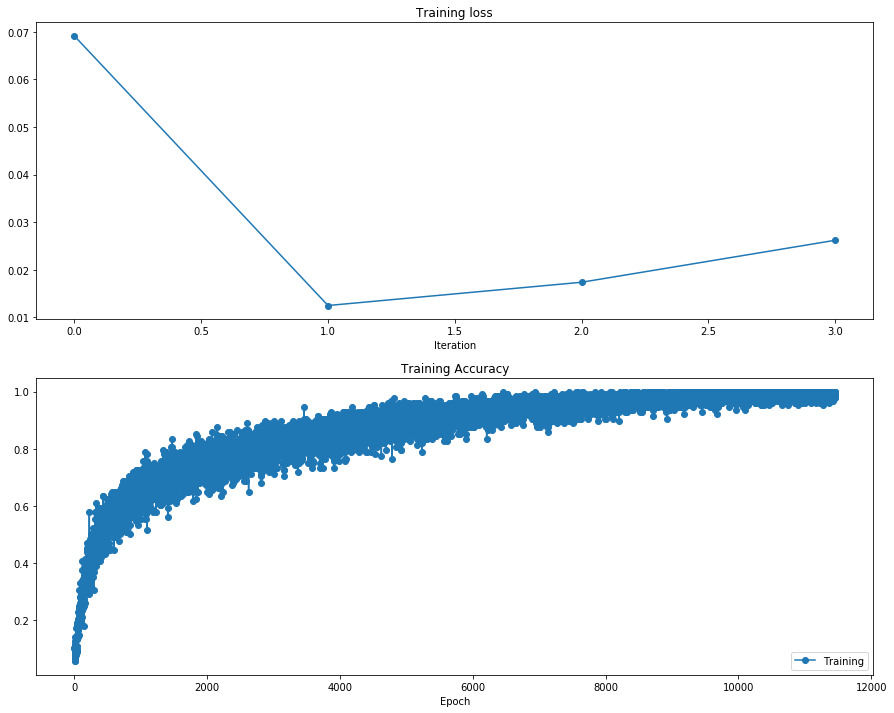

validation for epoch 29
-  epoch 29: validation accuracy = 0.743
***** test accuracy: 0.744
Model saved in lib/tf_models/problem2/csci-599_mine.ckpt


In [10]:
# Clear old computation graphs
tf.reset_default_graph()

sess = tf.Session()

#############################################################################
# TODO: Preprocessing                                                       #
#############################################################################
X_train_ = normalize(X_train)
X_val_ = normalize(X_val)
X_test_ = normalize(X_test)
#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################

model = YourModel()
model.train(sess, X_train_, Y_train, X_val_, Y_val)
accuracy = model.evaluate(sess, X_test_, Y_test)
print('***** test accuracy: %.3f' % accuracy)

# Save your model
saver = tf.train.Saver()
model_path = saver.save(sess, "lib/tf_models/problem2/csci-599_mine.ckpt")
print("Model saved in %s" % model_path)

sess.close()

In [11]:
tf.reset_default_graph()

# Load your model
model = YourModel()
sess = tf.Session()
saver = tf.train.Saver()
saver.restore(sess, "lib/tf_models/problem2/csci-599_mine.ckpt")

-----  Your model  -----
intput layer: (?, 32, 32, 3)
conv1 layer: (?, 16, 16, 32)
conv2 layer: (?, 8, 8, 64)
conv3 layer: (?, 4, 4, 128)
conv4 layer: (?, 2, 2, 256)
conv5 layer: (?, 1, 1, 512)
flat layer: (?, 512)
fc6 layer: (?, 1024)
fc7 layer: (?, 512)
fc8 layer: (?, 10)
INFO:tensorflow:Restoring parameters from lib/tf_models/problem2/csci-599_mine.ckpt
